**Check for duplicates and replace**

In [1]:
from pathlib import Path
import re

data_folder = Path("Data")
txt_files = list(data_folder.glob("*.txt"))

# Pattern to match files ending with (number).txt
pattern = re.compile(r"^(.*)\((\d+)\)\.txt$")

# Build a mapping: {base_name: [original, duplicate]}
file_map = {}

for file in txt_files:
    match = pattern.match(file.name)
    if match:
        base = match.group(1).strip() + ".txt"
        file_map.setdefault(base, {"original": None, "duplicate": None})
        file_map[base]["duplicate"] = file
    else:
        file_map.setdefault(file.name, {"original": None, "duplicate": None})
        file_map[file.name]["original"] = file

# Process files: delete original if duplicate exists, then rename duplicate
for base, files in file_map.items():
    orig = files["original"]
    dup = files["duplicate"]
    if orig and dup:
        print(f"Deleting original: {orig}")
        orig.unlink()  # Delete the original file
        # Rename duplicate to original name
        print(f"Renaming {dup} -> {orig}")
        dup.rename(data_folder / base)
    elif dup and not orig:
        # Just rename duplicate if original doesn't exist
        print(f"Renaming {dup} -> {data_folder / base}")
        dup.rename(data_folder / base)

**Import data and filter**

In [2]:
import pandas as pd
from pathlib import Path

data_folder = Path("Data")
txt_files = list(data_folder.glob("*.txt"))

dfs = []
files_with_unnamed = []

for file in txt_files:
    with open(file, encoding="latin1") as f:
        lines = f.readlines()
        # Extract station name from line 2
        station_line = lines[1].strip() if len(lines) > 1 else ""
        station_name = station_line.split(":", 1)[-1].strip() if ":" in station_line else station_line

    # Only import if station name contains 'Valencia' or 'València'
    if not ("valencia" in station_name.lower() or "valència" in station_name.lower()):
        continue

    # Find the header row index (row where first column starts with FECHA)
    header_idx = None
    for idx, line in enumerate(lines):
        first_col = line.strip().split('\t')[0].upper()
        if first_col.startswith("FECHA"):
            header_idx = idx
            break
    if header_idx is None:
        print(f"Header not found in {file.name}, skipping.")
        continue

    # Parse header and data, skipping units row
    header = lines[header_idx].strip().split('\t')
    data_lines = lines[header_idx + 2:]  # skip units row

    # Remove empty headers and their corresponding columns in data
    keep_indices = [i for i, h in enumerate(header) if h and not h.startswith("Unnamed")]
    clean_header = [header[i] for i in keep_indices]

    data = []
    for line in data_lines:
        row = line.strip().split('\t')
        # Only keep columns with real headers
        clean_row = [row[i] if i < len(row) else None for i in keep_indices]
        data.append(clean_row)

    df = pd.DataFrame(data, columns=clean_header)
    # Remove columns where all values are 'V'
    df = df.loc[:, ~(df == 'V').all()]
    df["Estacion"] = station_name

    # Check for unnamed columns
    unnamed = [col for col in df.columns if "Unnamed" in col]
    if unnamed:
        print(f"{file.name} has unnamed columns: {unnamed}")
        files_with_unnamed.append(file.name)
    dfs.append(df)

data_AQ_VLC = pd.concat(dfs, ignore_index=True)

# Show all unique column names alphabetically
all_columns = sorted(data_AQ_VLC.columns)
print("\nAll column names (alphabetical):")
for col in all_columns:
    print(col)

print(data_AQ_VLC.dtypes)


All column names (alphabetical):
Benceno
C6H6
C7H8
C8H10
CH4
CO
Direc.
Estacion
FECHA
FECHA Y HORA
H.Rel.
HCT
HNM
HORA
NH3
NO
NO2
NOx
O3
PM1
PM10
PM10 
PM10grimm
PM1grimm
PM2.5
PM2.5grimm
PST
Precip.
Pres.
R.Sol.
Ruido
SO2
Temp.
Tolueno
Veloc.
Veloc.máx.
Xileno
FECHA           object
HORA            object
SO2             object
PST             object
CO              object
NO              object
NO2             object
NOx             object
O3              object
Ruido           object
Veloc.          object
Direc.          object
Temp.           object
H.Rel.          object
Pres.           object
R.Sol.          object
Estacion        object
PM10            object
FECHA Y HORA    object
PM10            object
Veloc.máx.      object
C7H8            object
C6H6            object
PM2.5           object
PM1             object
C8H10           object
Tolueno         object
Benceno         object
Xileno          object
PM2.5grimm      object
PM10grimm       object
PM1grimm        object
C

**Further filtering and removal of duplicates**

In [3]:
import numpy as np

def merge_complementary(df, prefix, exclude_prefixes=None):
    cols = [col for col in df.columns if col.upper().startswith(prefix.upper())]
    if exclude_prefixes:
        cols = [col for col in cols if not any(col.upper().startswith(ex.upper()) for ex in exclude_prefixes)]
    if len(cols) > 1:
        print(f"{prefix} columns found: {cols}")
        nonempty = df[cols].replace('', np.nan).notna().sum(axis=1)
        overlap_rows = df[nonempty > 1]
        if not overlap_rows.empty:
            print(f"Rows with overlapping {prefix} data (more than one non-empty value):")
            display(overlap_rows[cols])
        else:
            print(f"All {prefix} columns are complementary. Merging into one.")
            # Use apply to select the first non-null value in each row
            merged = df[cols].apply(lambda row: next((x for x in row if pd.notna(x) and x != ''), np.nan), axis=1)
            df[prefix + "_merged"] = merged
            df.drop(columns=cols, inplace=True)
    elif len(cols) == 1:
        df[prefix + "_merged"] = df[cols[0]]
        df.drop(columns=cols, inplace=True)
    else:
        print(f"No {prefix} columns found.")
    return df

# PM10
data_AQ_VLC = merge_complementary(data_AQ_VLC, "PM10")
# PM1 (excluding PM10)
data_AQ_VLC = merge_complementary(data_AQ_VLC, "PM1", exclude_prefixes=["PM10"])
# PM2 (includes PM2.5, PM2_5, etc.)
data_AQ_VLC = merge_complementary(data_AQ_VLC, "PM2")
# Veloc
data_AQ_VLC = merge_complementary(data_AQ_VLC, "VELOC")
# Direc
data_AQ_VLC = merge_complementary(data_AQ_VLC, "DIREC")
# Precip
data_AQ_VLC = merge_complementary(data_AQ_VLC, "PRECIP")

print(data_AQ_VLC.dtypes)

# Convert all columns except 'Estacion' and 'FECHA Y HORA' to numeric
for col in data_AQ_VLC.columns:
    if col not in ["Estacion", "FECHA Y HORA", "FECHA", "HORA"]:
        data_AQ_VLC[col] = pd.to_numeric(data_AQ_VLC[col], errors='coerce')


print(data_AQ_VLC.dtypes)


PM10 columns found: ['PM10', 'PM10 ', 'PM10grimm']
All PM10 columns are complementary. Merging into one.
PM1 columns found: ['PM1', 'PM1grimm']
All PM1 columns are complementary. Merging into one.
PM2 columns found: ['PM2.5', 'PM2.5grimm']
All PM2 columns are complementary. Merging into one.
VELOC columns found: ['Veloc.', 'Veloc.máx.']
Rows with overlapping VELOC data (more than one non-empty value):


,Veloc.,Veloc.máx.
28194,"0,1","0,1"
28195,"0,1","0,1"
28196,"0,1","0,1"
28197,"0,1","0,1"
28198,"0,1","0,13"
...,...,...
1229164,"6,3","12,1"
1229165,"5,7","10,9"
1229166,"4,9","10,2"
1229167,"4,7","10,2"


FECHA            object
HORA             object
SO2              object
PST              object
CO               object
NO               object
NO2              object
NOx              object
O3               object
Ruido            object
Veloc.           object
Temp.            object
H.Rel.           object
Pres.            object
R.Sol.           object
Estacion         object
FECHA Y HORA     object
Veloc.máx.       object
C7H8             object
C6H6             object
C8H10            object
Tolueno          object
Benceno          object
Xileno           object
CH4              object
HCT              object
HNM              object
NH3              object
PM10_merged      object
PM1_merged       object
PM2_merged       object
DIREC_merged     object
PRECIP_merged    object
dtype: object
FECHA             object
HORA              object
SO2              float64
PST              float64
CO               float64
NO               float64
NO2              float64
NOx              fl

**unify timestamps**

In [4]:
# Check timestamp completeness logic
mask_fyh_missing = data_AQ_VLC["FECHA Y HORA"].isna() | (data_AQ_VLC["FECHA Y HORA"] == "")
mask_fecha_present = data_AQ_VLC["FECHA"].notna() & (data_AQ_VLC["FECHA"] != "")
mask_hora_present = data_AQ_VLC["HORA"].notna() & (data_AQ_VLC["HORA"] != "")

# Rows where FECHA Y HORA is missing but FECHA or HORA is also missing
problem_rows = data_AQ_VLC[mask_fyh_missing & ~(mask_fecha_present & mask_hora_present)]

print(f"Number of problematic rows: {len(problem_rows)}")
if not problem_rows.empty:
    display(problem_rows[["FECHA Y HORA", "FECHA", "HORA"]])
else:
    print("All rows have either FECHA Y HORA or both FECHA and HORA present.")

# 1. Print a sample of unique values
print("Sample unique 'FECHA Y HORA' values:")
print(data_AQ_VLC["FECHA Y HORA"].dropna().unique()[:20])

# 2. Try parsing all values
parsed = pd.to_datetime(data_AQ_VLC["FECHA Y HORA"], errors='coerce', dayfirst=True)

# 3. Count successes and failures
n_total = data_AQ_VLC["FECHA Y HORA"].notna().sum()
n_parsed = parsed.notna().sum()
n_failed = n_total - n_parsed

print(f"\nTotal non-null 'FECHA Y HORA': {n_total}")
print(f"Successfully parsed: {n_parsed}")
print(f"Failed to parse: {n_failed}")

# 4. Show a few failed examples
failed_examples = data_AQ_VLC.loc[data_AQ_VLC["FECHA Y HORA"].notna() & parsed.isna(), "FECHA Y HORA"].unique()
print("\nExamples of failed to parse:")
print(failed_examples[:10])


# Try parsing FECHA Y HORA first
dt_fyh = pd.to_datetime(data_AQ_VLC["FECHA Y HORA"], errors='coerce', dayfirst=True)

# For rows where FECHA Y HORA is missing, combine FECHA and HORA and parse
mask_missing = dt_fyh.isna()
dt_fh = pd.to_datetime(
    data_AQ_VLC["FECHA"].astype(str).str.strip() + " " + data_AQ_VLC["HORA"].astype(str).str.strip(),
    errors='coerce', dayfirst=True
)

# Create the new Datetime column
data_AQ_VLC["Datetime"] = dt_fyh
data_AQ_VLC.loc[mask_missing, "Datetime"] = dt_fh[mask_missing]


Number of problematic rows: 0
All rows have either FECHA Y HORA or both FECHA and HORA present.
Sample unique 'FECHA Y HORA' values:
['1/1/2011 1:00' '1/1/2011 2:00' '1/1/2011 3:00' '1/1/2011 4:00'
 '1/1/2011 5:00' '1/1/2011 6:00' '1/1/2011 7:00' '1/1/2011 8:00'
 '1/1/2011 9:00' '1/1/2011 10:00' '1/1/2011 11:00' '1/1/2011 12:00'
 '1/1/2011 13:00' '1/1/2011 14:00' '1/1/2011 15:00' '1/1/2011 16:00'
 '1/1/2011 17:00' '1/1/2011 18:00' '1/1/2011 19:00' '1/1/2011 20:00']

Total non-null 'FECHA Y HORA': 61320
Successfully parsed: 61320
Failed to parse: 0

Examples of failed to parse:
[]


**Unify station name**

In [5]:
import re

# 1. Extract numeric codes from the Estacion column
def extract_code(estacion):
    # Looks for a 8-digit code in the string
    match = re.search(r'(\d{8})', str(estacion))
    return match.group(1) if match else None

data_AQ_VLC['Codigo'] = data_AQ_VLC['Estacion'].apply(extract_code)

# 2. See which codes are present and how many unique names per code
code_to_names = data_AQ_VLC.groupby('Codigo')['Estacion'].unique()
print("Codes with multiple names:")
for code, names in code_to_names.items():
    if len(names) > 1:
        print(f"{code}: {names}")

# 3. Create a mapping from code to unified name (edit as needed)
code_name_map = {
    '46250047': 'Av. França',
    '46250030': 'Pista de Silla',
    '46250034': 'Linares',
    '46250046': 'Politècnic',
    '46250050': 'Bulevard Sur',
    '46250043': 'Vivers',
    '46250048': 'Molí del Sol',
    '46250031': 'Nuevo Centro',
    '46250049': 'Conselleria Meteo',
    '46250051': 'Albufera',
    '46250054': 'Centre',
    '46250055': 'Olivereta',
    '46250301': 'Port moll transit',
    '46250302': 'Port llit Turia',
    '46250900': 'Natzaret',
    # Add more mappings as needed, e.g.:
    # '462500XX': 'Station Name',
}

# 4. Replace Estacion with unified name where code matches
def unify_estacion(row):
    code = row['Codigo']
    return code_name_map.get(code, row['Estacion'])

data_AQ_VLC['Estacion'] = data_AQ_VLC.apply(unify_estacion, axis=1)  # type: ignore

# 5. Drop the helper column if you want
data_AQ_VLC = data_AQ_VLC.drop(columns=['Codigo'])

Codes with multiple names:
46250030: ['46250030-València - Pista de Silla'
 'València - Pista de Silla\tCODIGO:46250030']
46250034: ['València - Linares\tCODIGO:46250034' '46250034-València - Linares']
46250043: ['46250043-València - Vivers' 'València - Vivers\tCODIGO:46250043']
46250046: ['46250046-València - Politècnic' 'València - Politècnic\tCODIGO:46250046']
46250047: ['46250047-València - Avd. Francia'
 'València - Avd. Francia\tCODIGO:46250047'
 '46250047-València - Av. França']
46250048: ['46250048-València - Molí del Sol'
 'València - Molí del Sol\tCODIGO:46250048']
46250050: ['46250050-València - Bulevard Sud'
 'València - Bulevard Sud\tCODIGO:46250050']


**Visualization**

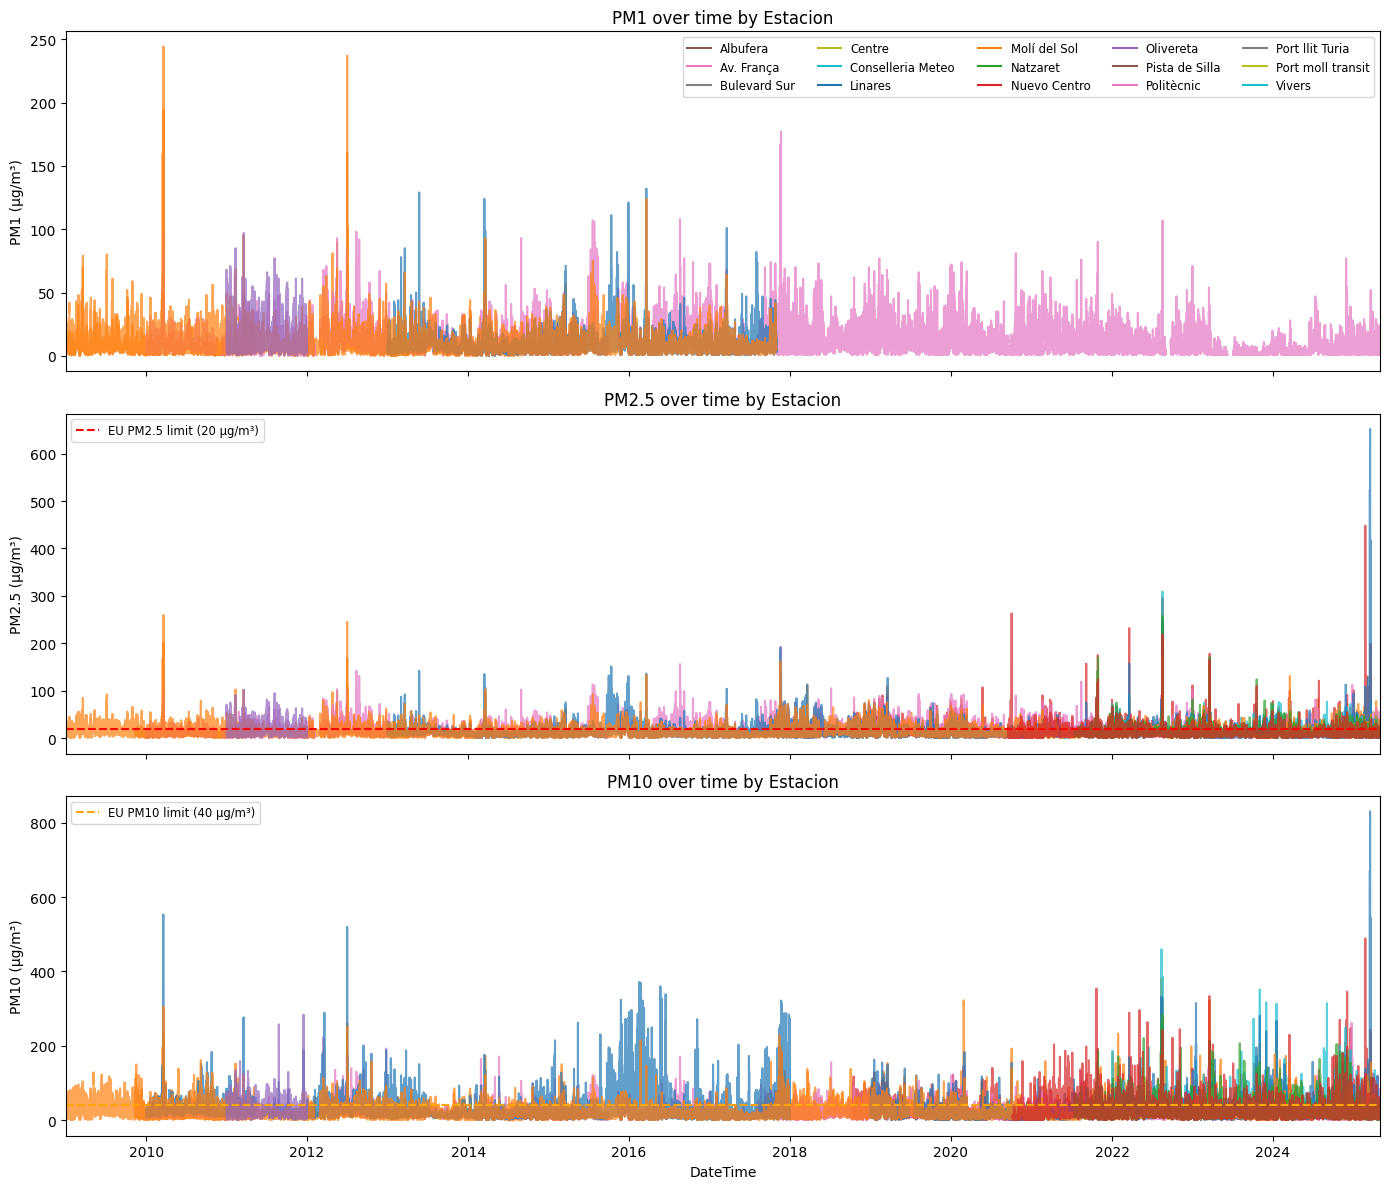

In [6]:
import matplotlib.pyplot as plt

# Select columns for plotting
pm_columns = {
    "PM1_merged": "PM1",
    "PM2_merged": "PM2.5",
    "PM10_merged": "PM10"
}

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

dt_min = data_AQ_VLC["Datetime"].min()
dt_max = data_AQ_VLC["Datetime"].max()

for idx, (ax, (col, label)) in enumerate(zip(axes, pm_columns.items())):
    if col in data_AQ_VLC.columns:
        # Plot station lines without legend
        for est, group in data_AQ_VLC.groupby("Estacion"):
            ax.plot(group["Datetime"], group[col], alpha=0.7, label="_nolegend_")
        ax.set_ylabel(f"{label} (µg/m³)")
        ax.set_title(f"{label} over time by Estacion")
        ax.set_xlim(dt_min, dt_max)
        # Draw EU safety levels and legends
        if col == "PM2_merged":
            ax.plot([dt_min, dt_max], [20, 20], color='red', linestyle='--', linewidth=1.5, label="EU PM2.5 limit (20 µg/m³)")
            ax.legend(loc='upper left', fontsize='small')
        elif col == "PM10_merged":
            ax.plot([dt_min, dt_max], [40, 40], color='orange', linestyle='--', linewidth=1.5, label="EU PM10 limit (40 µg/m³)")
            ax.legend(loc='upper left', fontsize='small')
        elif col == "PM1_merged":
            # Only show station legend in the top plot
            for est, group in data_AQ_VLC.groupby("Estacion"):
                ax.plot([], [], label=est)  # Dummy lines for legend
            ax.legend(loc='upper right', fontsize='small', ncols=5)

axes[-1].set_xlabel("DateTime")

plt.subplots_adjust(hspace=0.1)  # Remove vertical space between plots

plt.tight_layout()
plt.show()

**Data Availability Analysis**

Analyzing data availability for: ['SO2', 'PST', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'Ruido', 'Veloc.', 'Temp.', 'H.Rel.', 'Pres.', 'R.Sol.', 'Veloc.máx.', 'C7H8', 'C6H6', 'C8H10', 'Tolueno', 'Benceno', 'Xileno', 'CH4', 'HCT', 'HNM', 'NH3', 'PM10_merged', 'PM1_merged', 'PM2_merged', 'DIREC_merged', 'PRECIP_merged', 'Date', 'Date_Week']


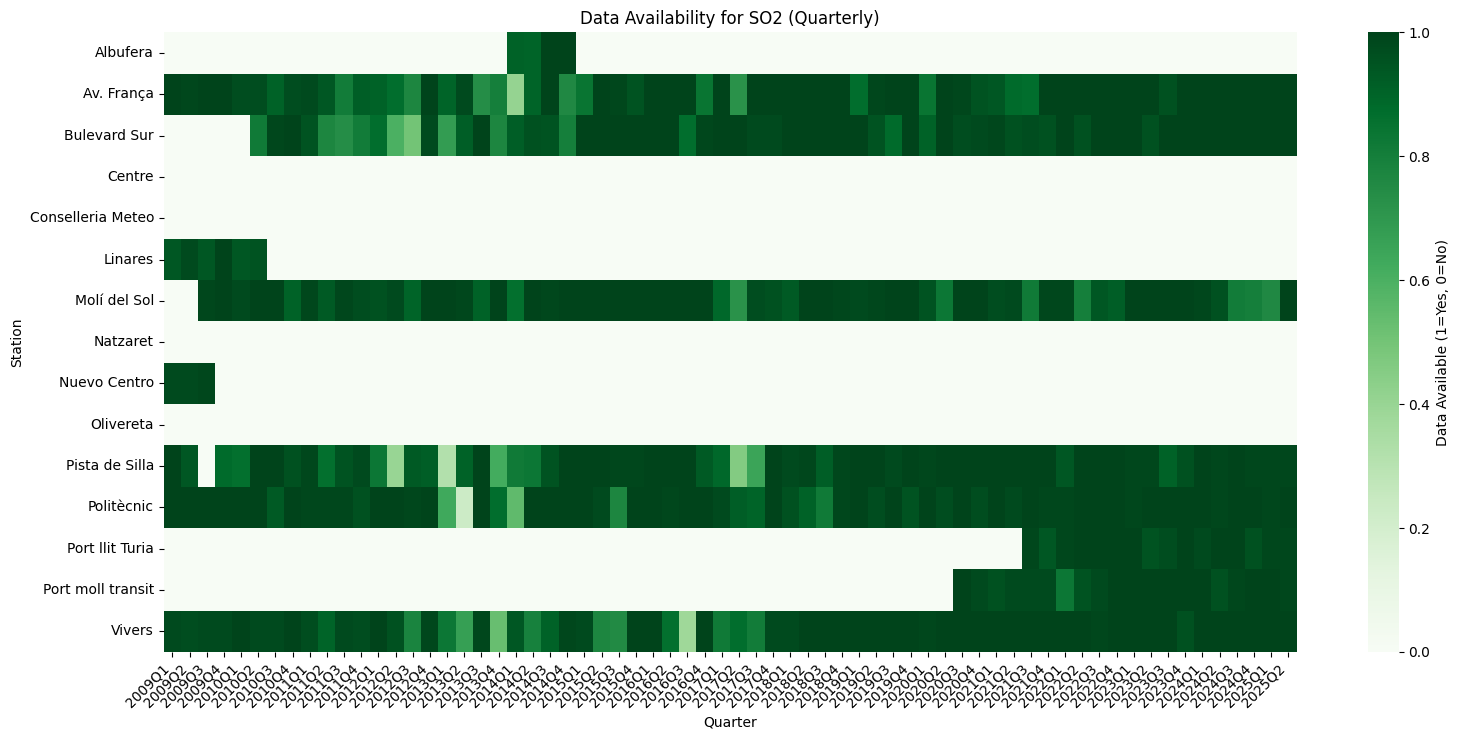

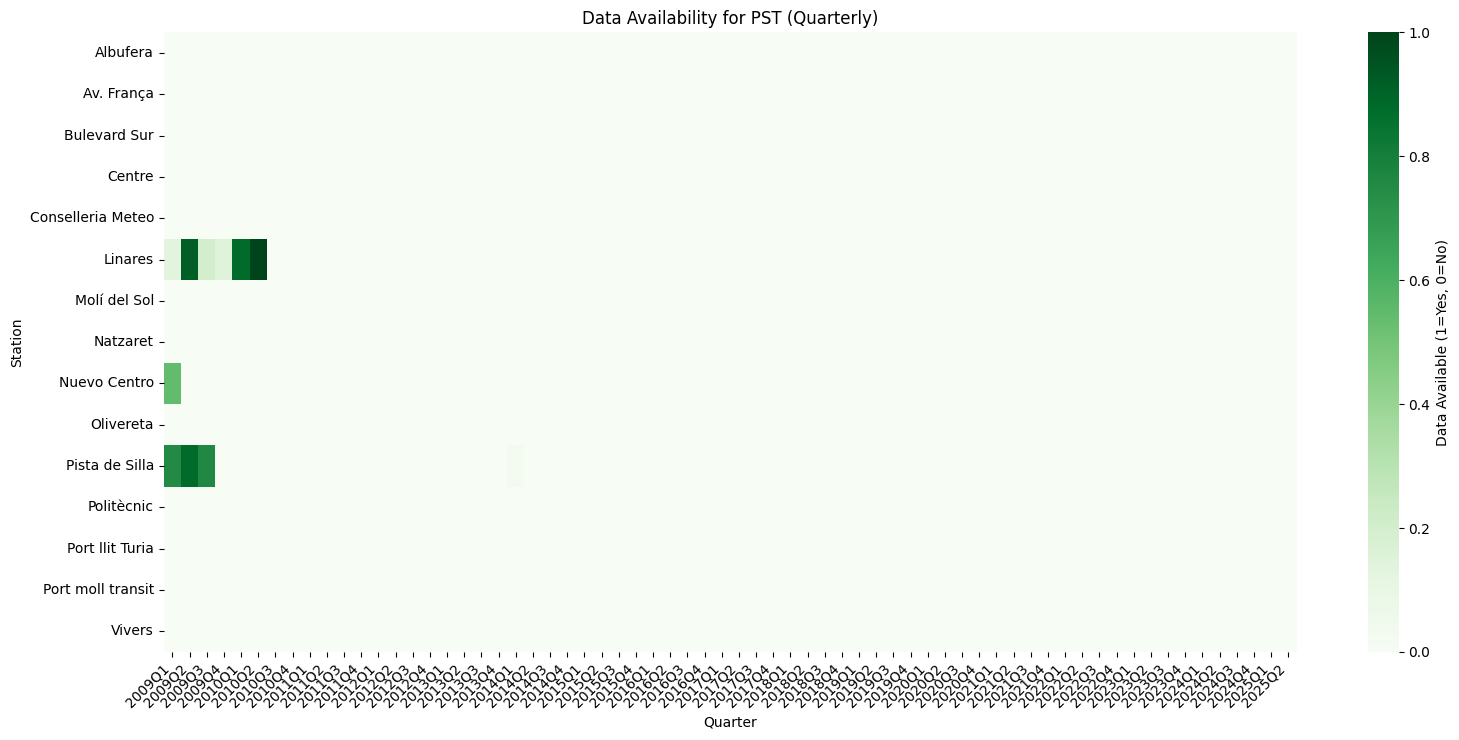

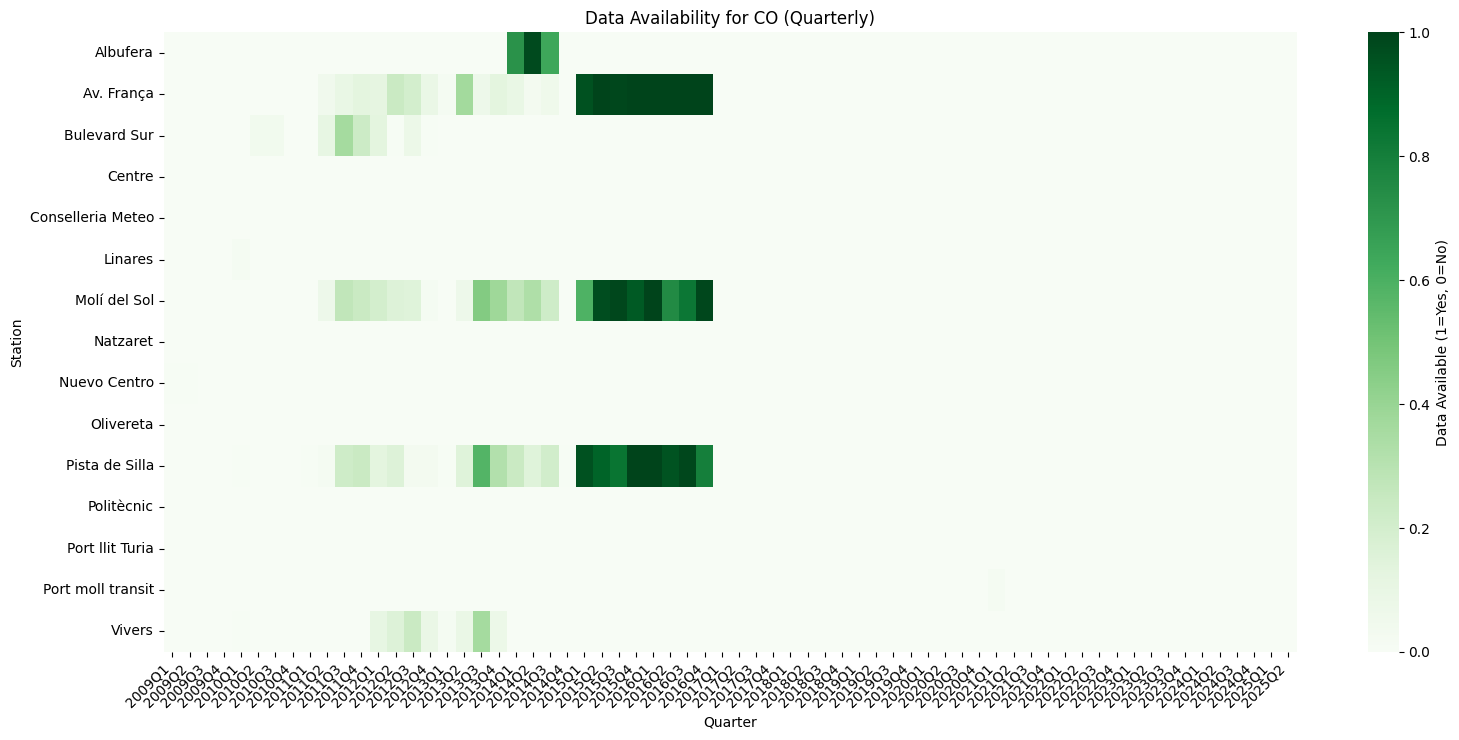

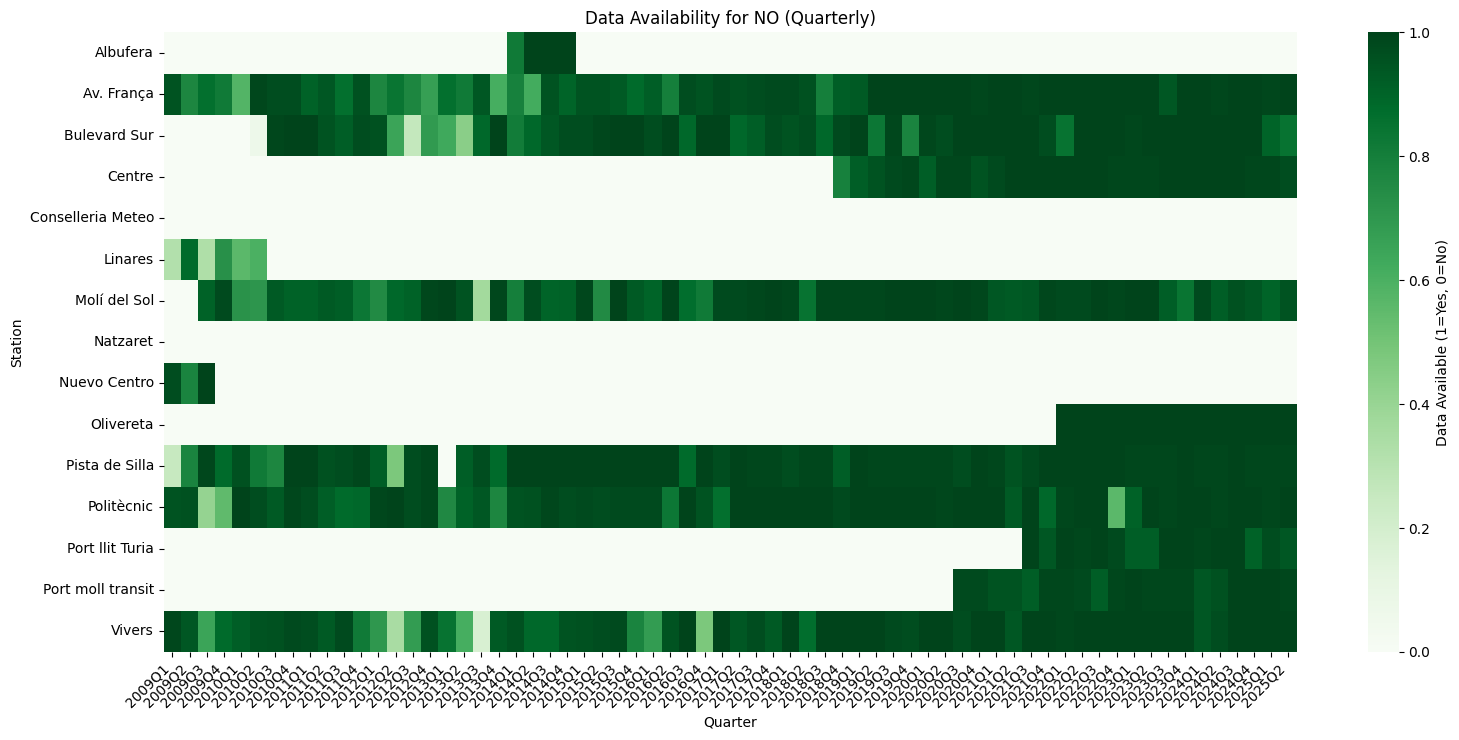

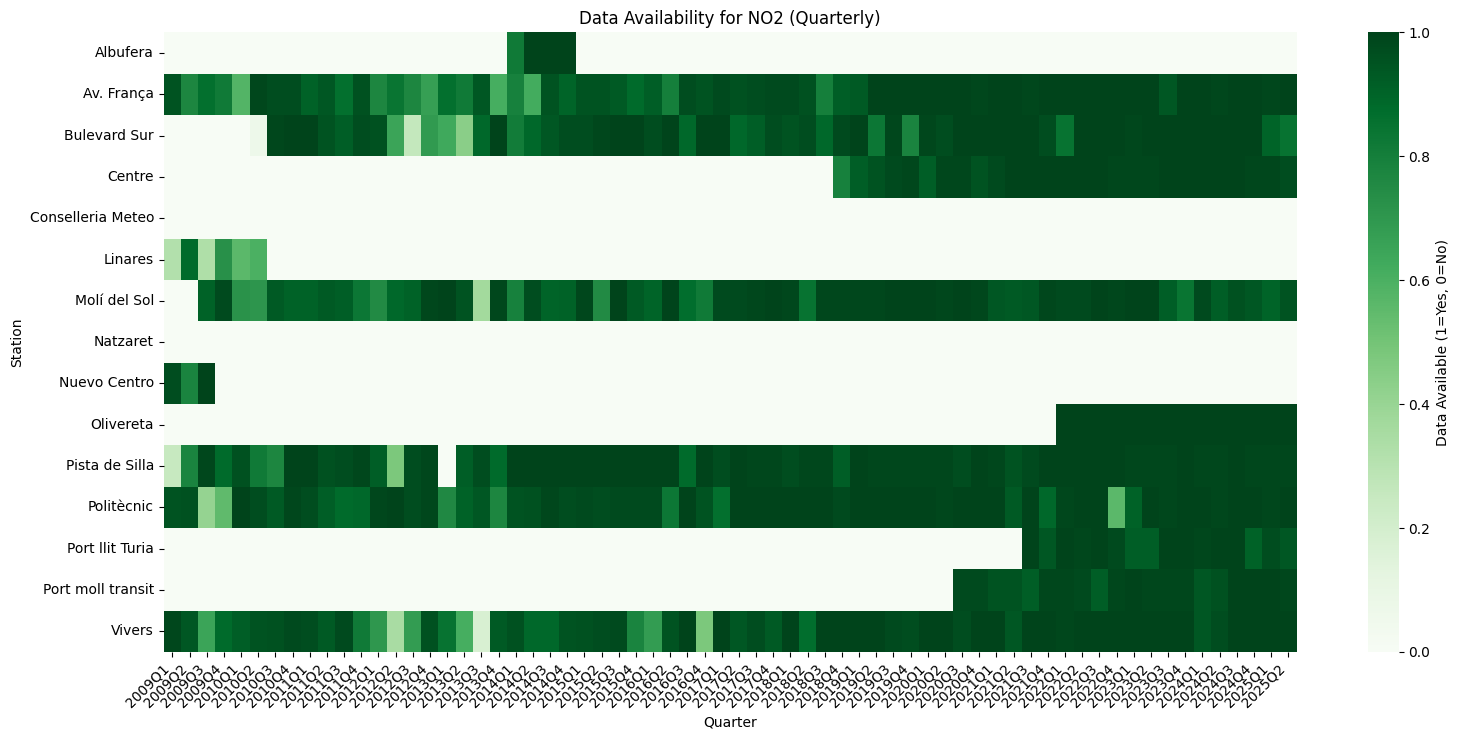

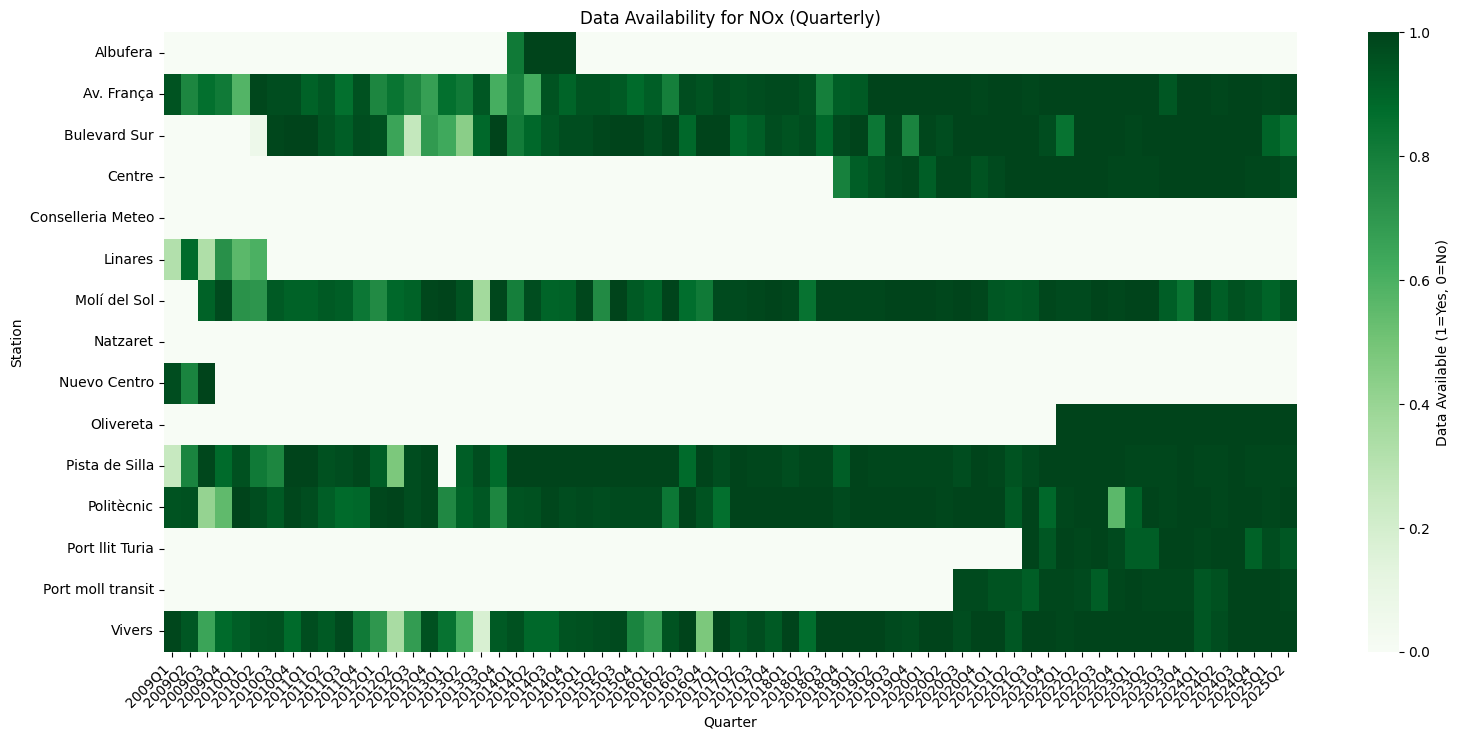

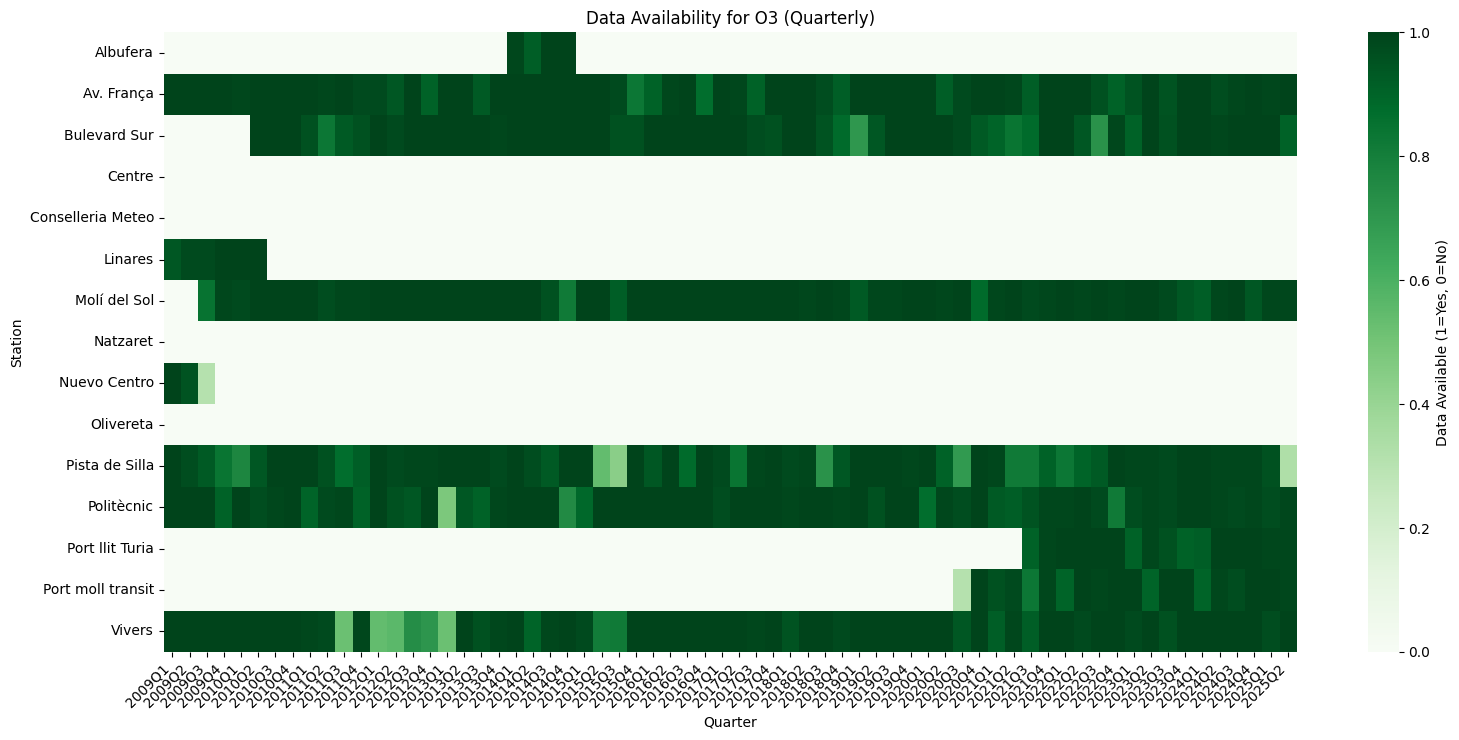

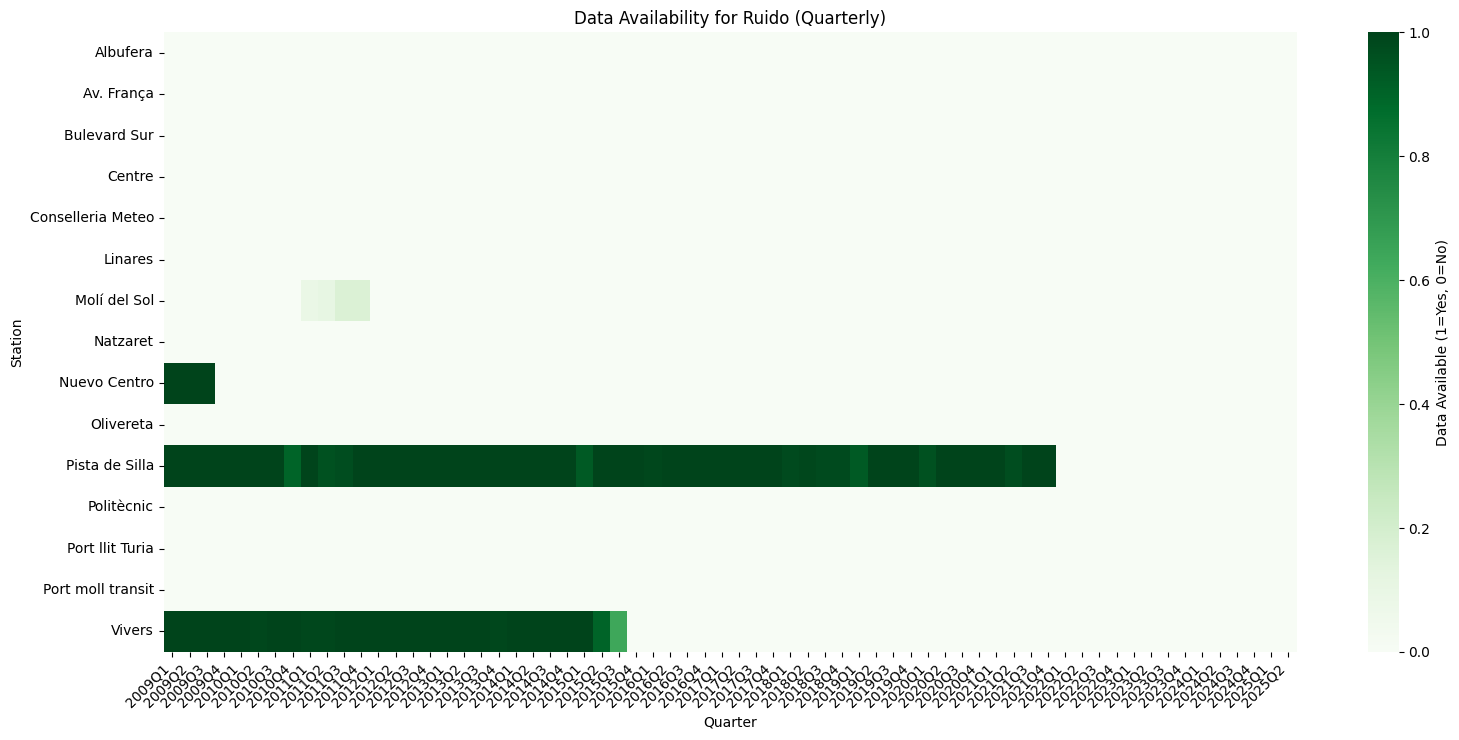

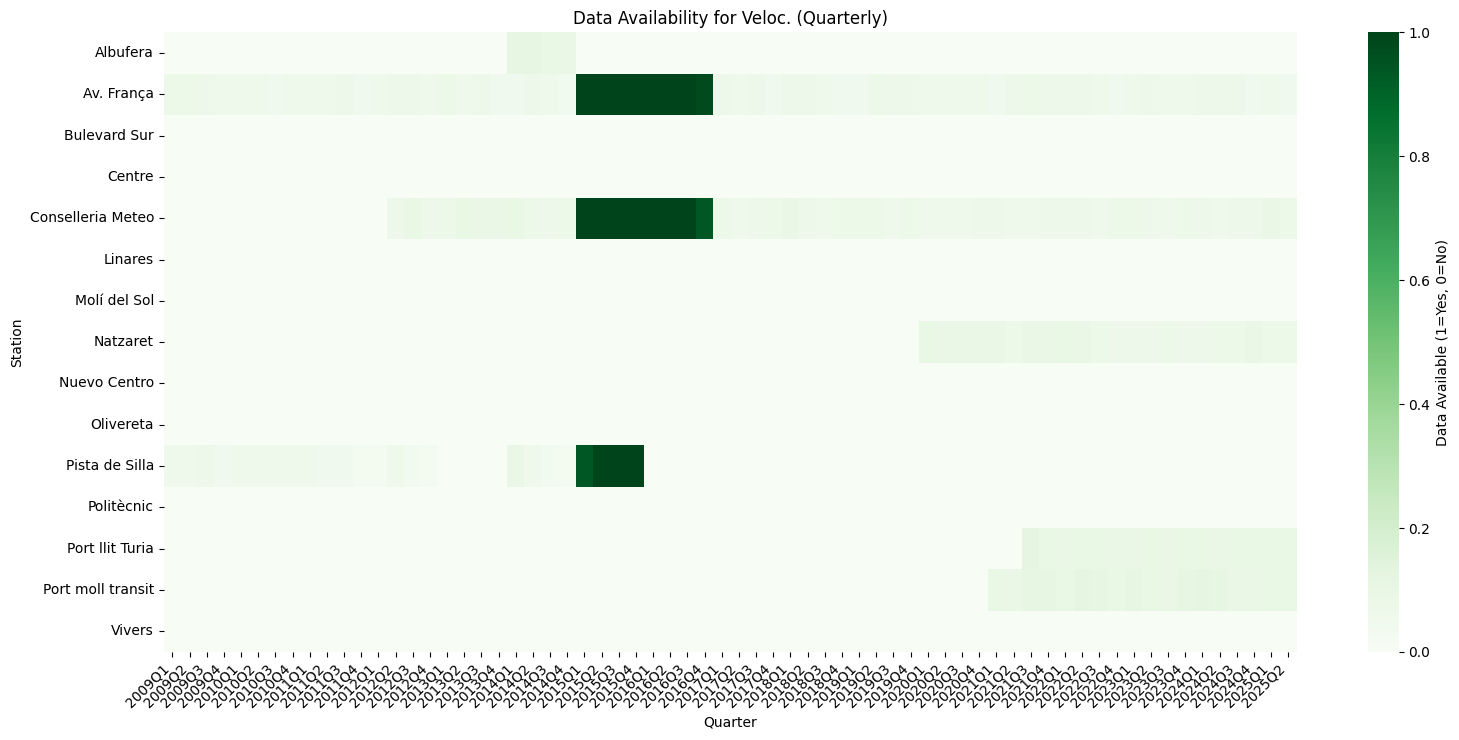

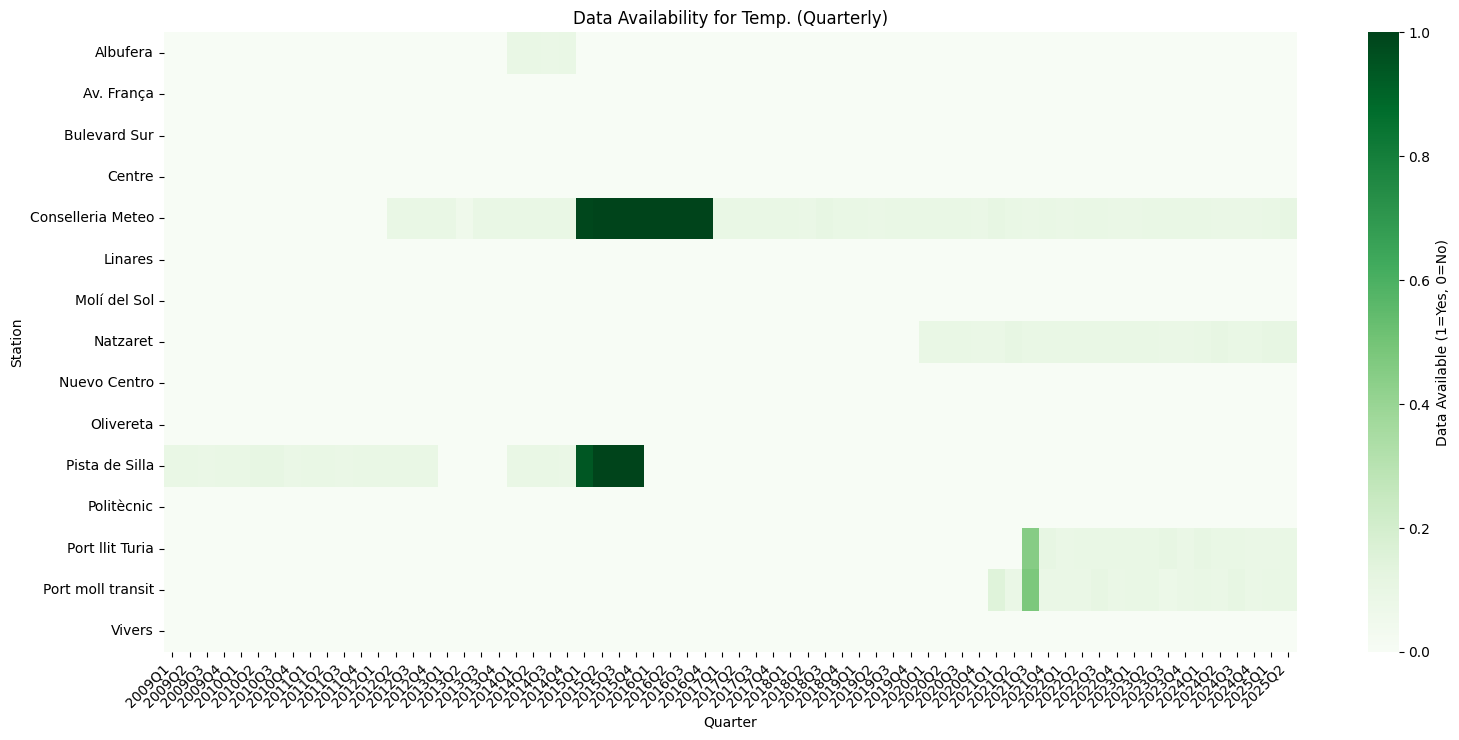

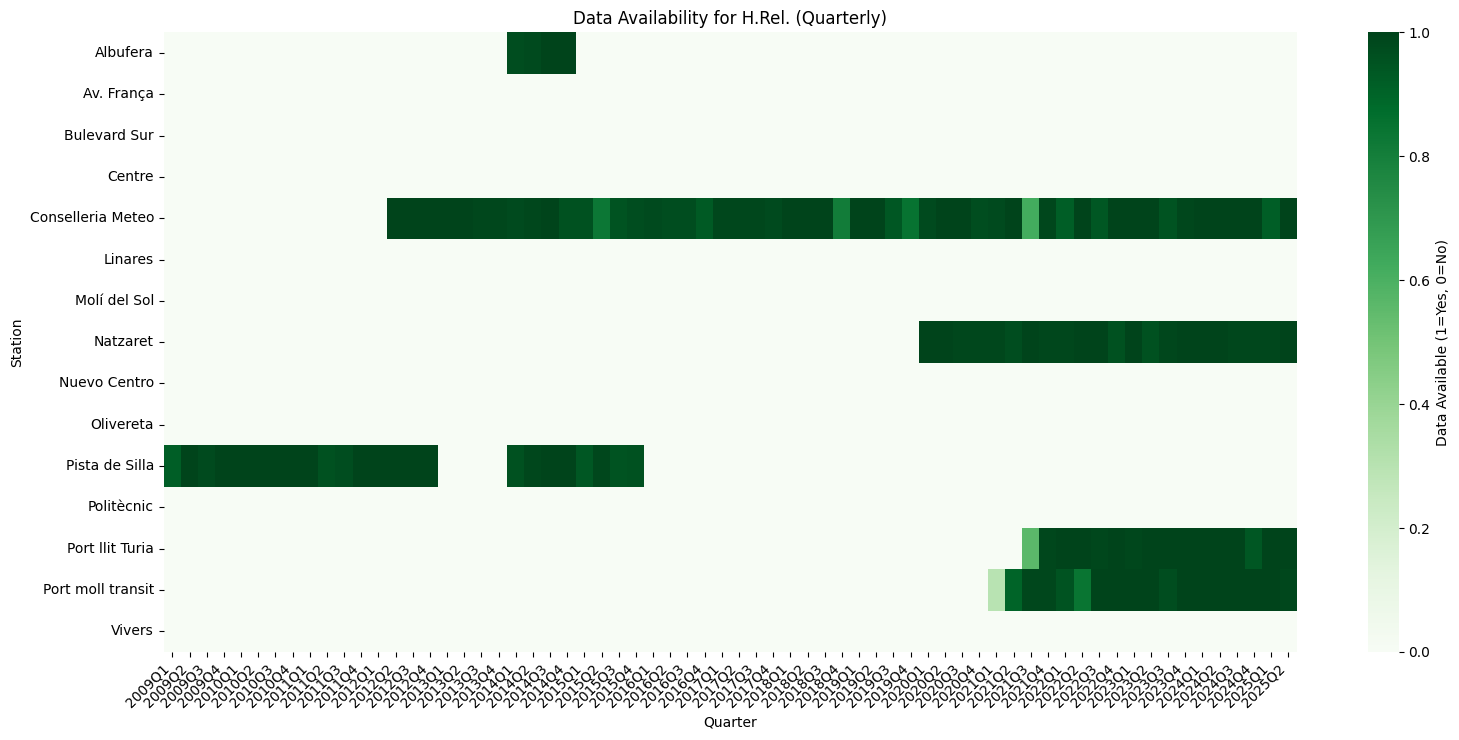

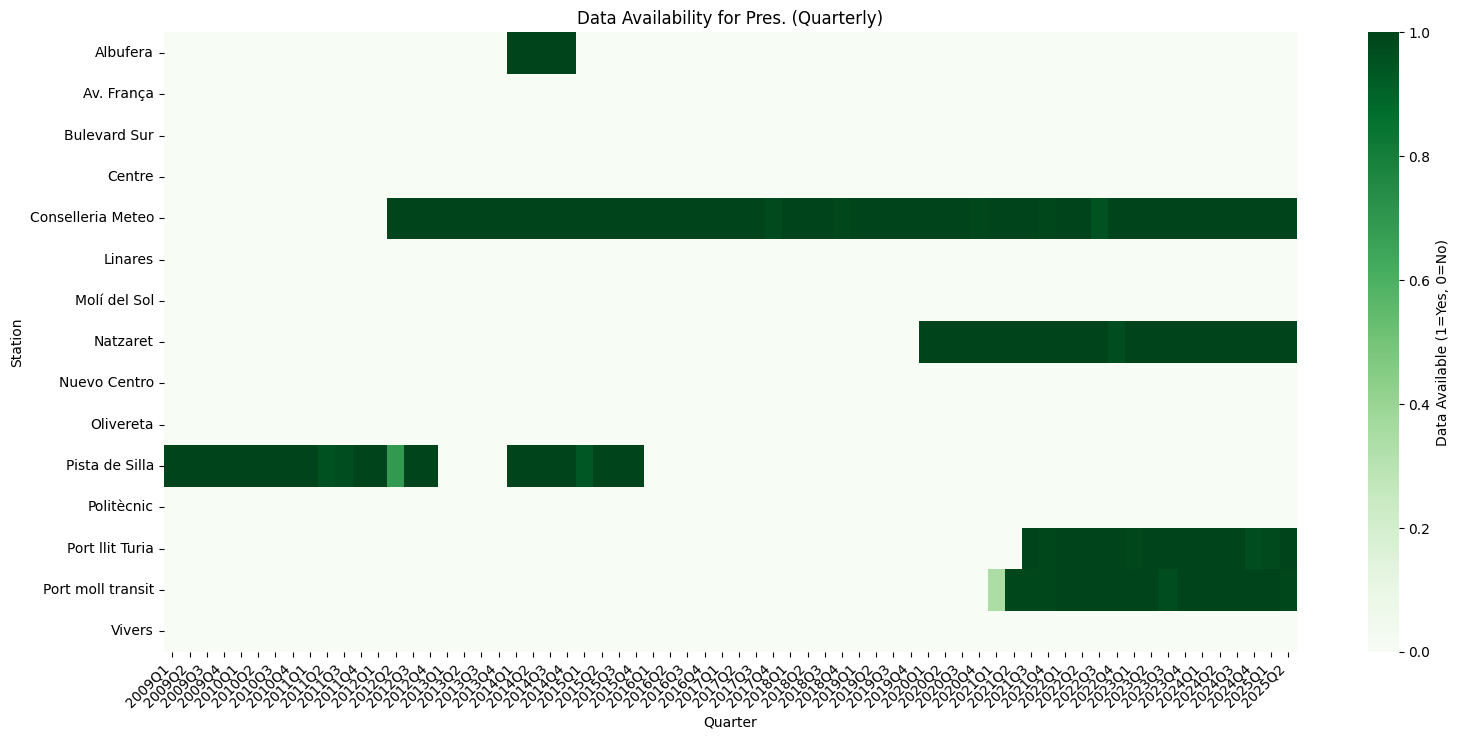

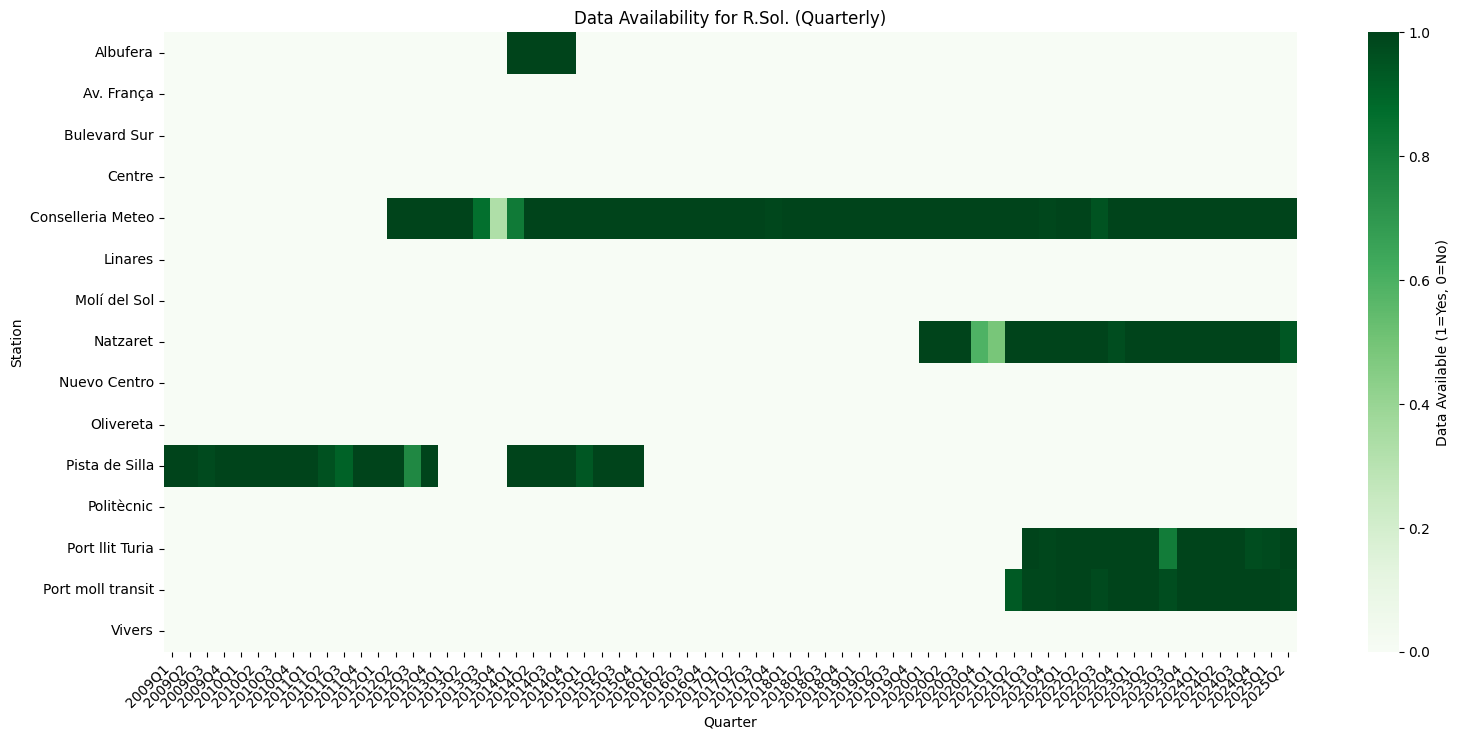

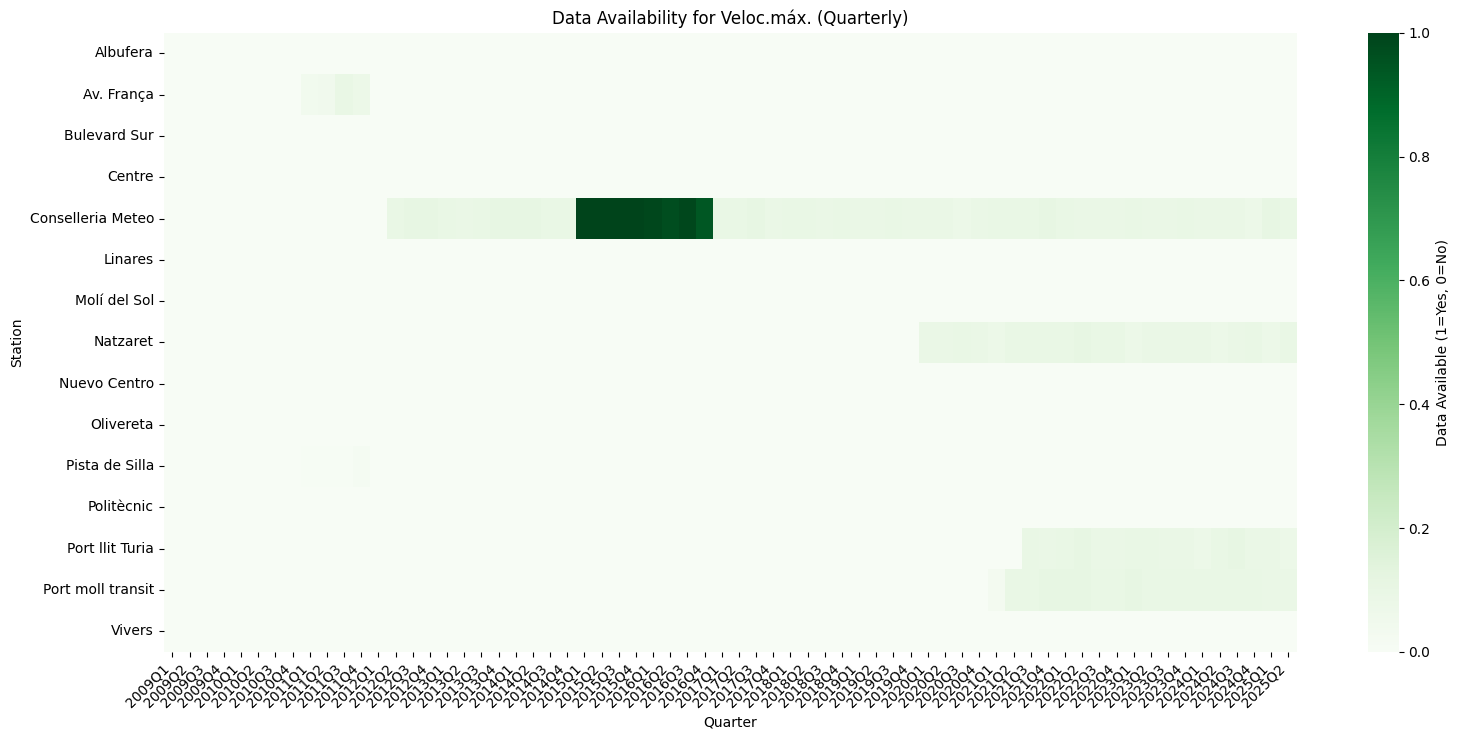

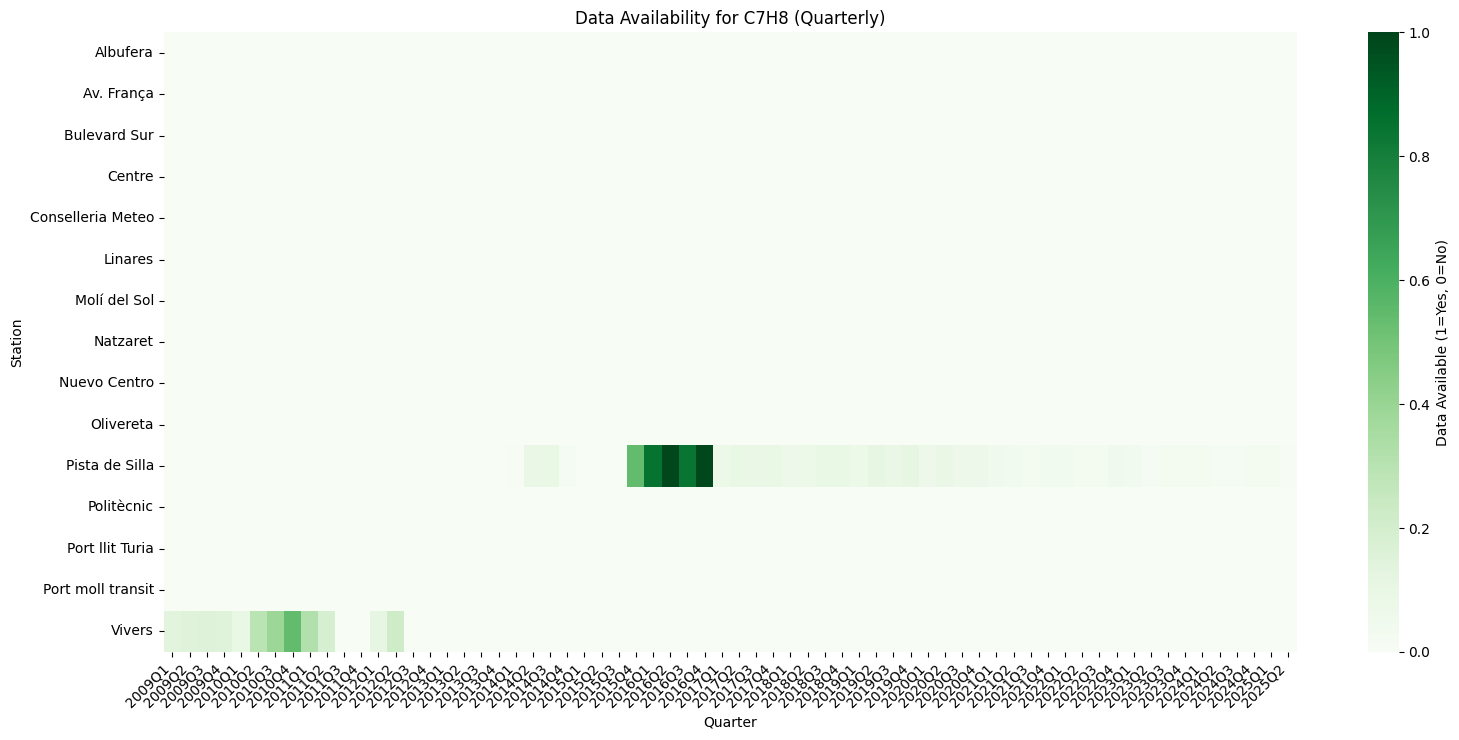

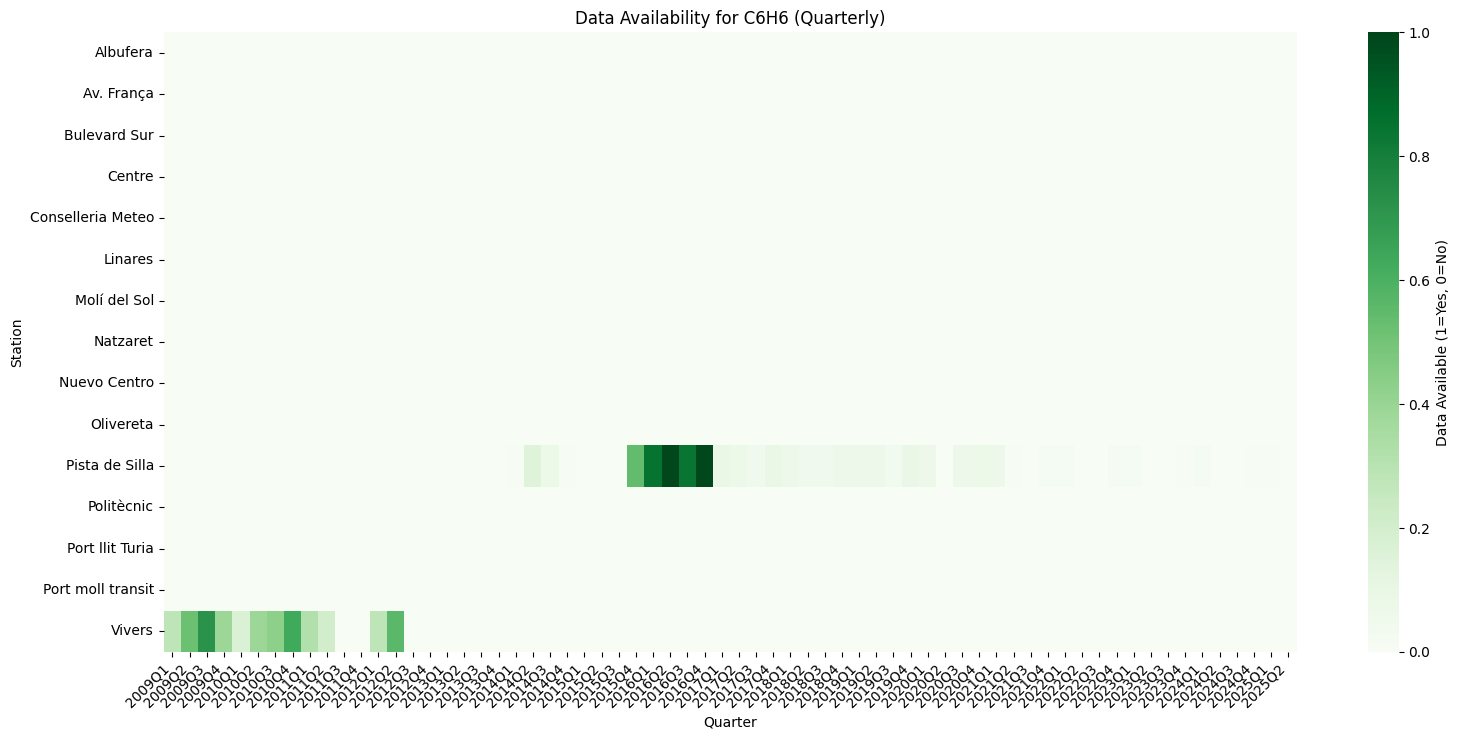

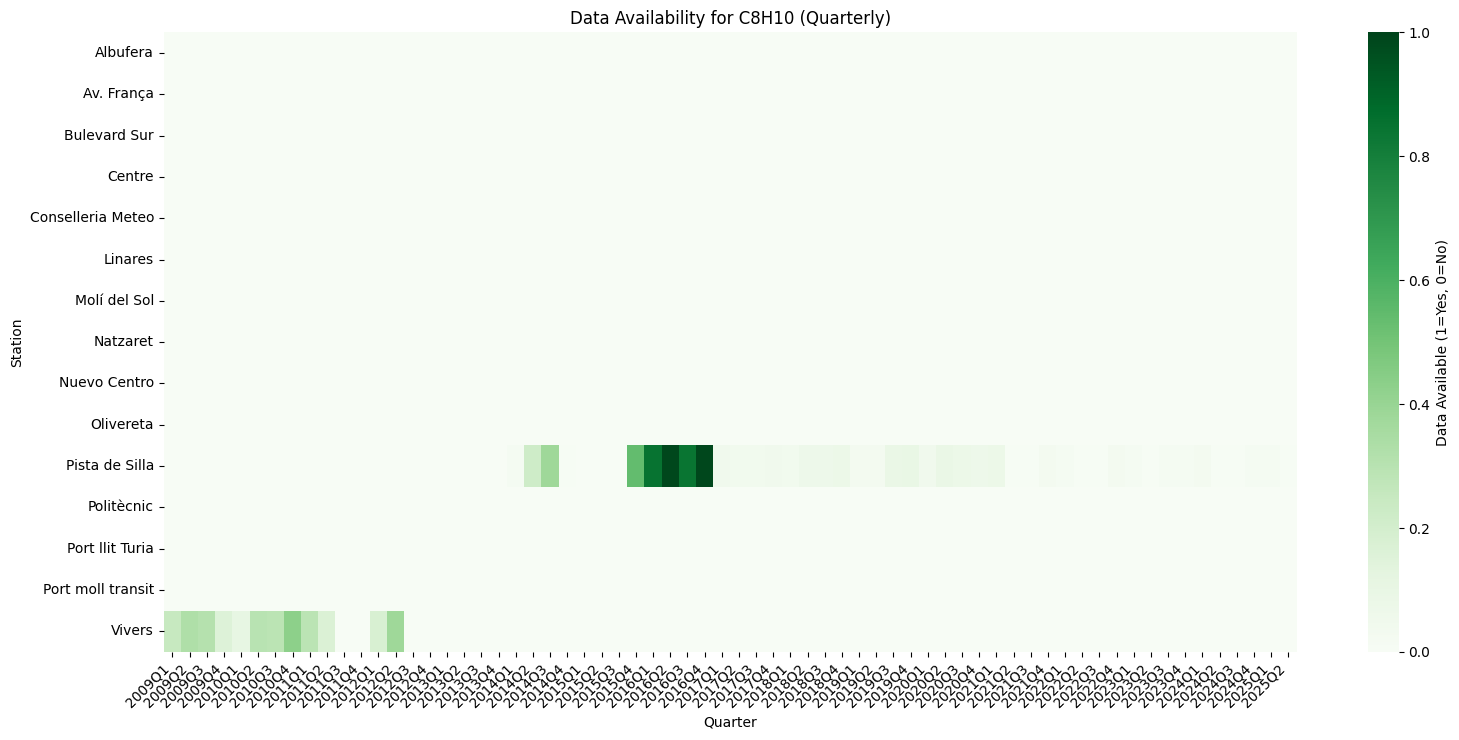

No data available for Tolueno, skipping plot.
No data available for Benceno, skipping plot.
No data available for Xileno, skipping plot.
No data available for CH4, skipping plot.
No data available for HCT, skipping plot.
No data available for HNM, skipping plot.


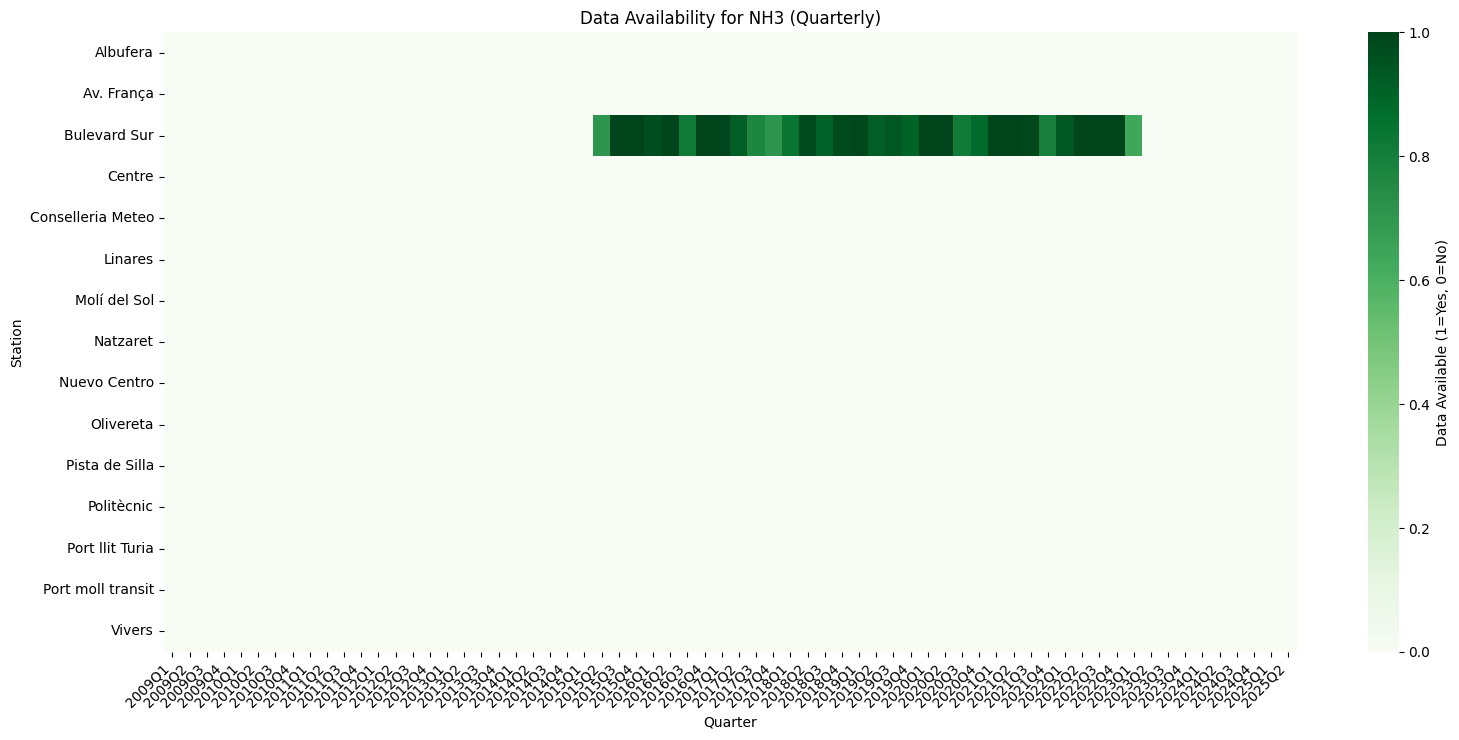

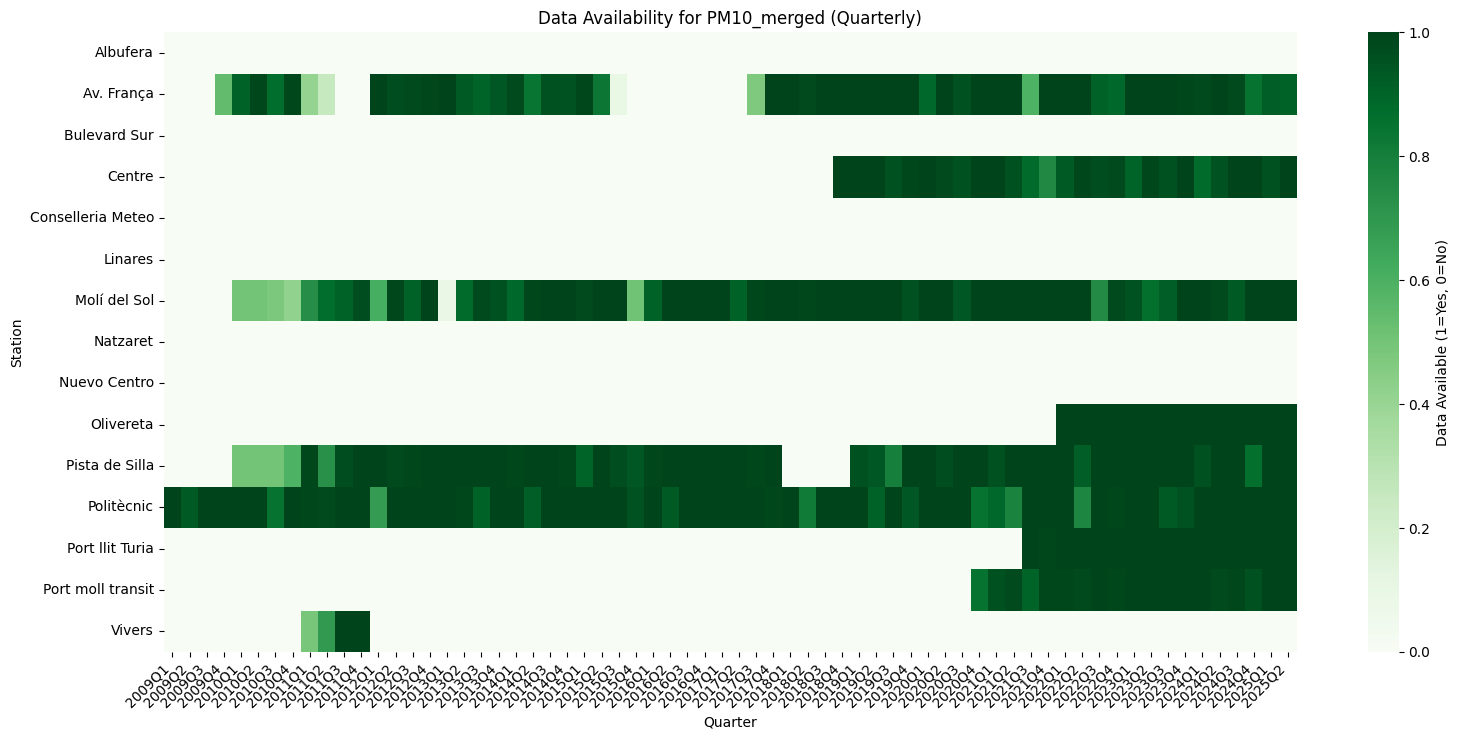

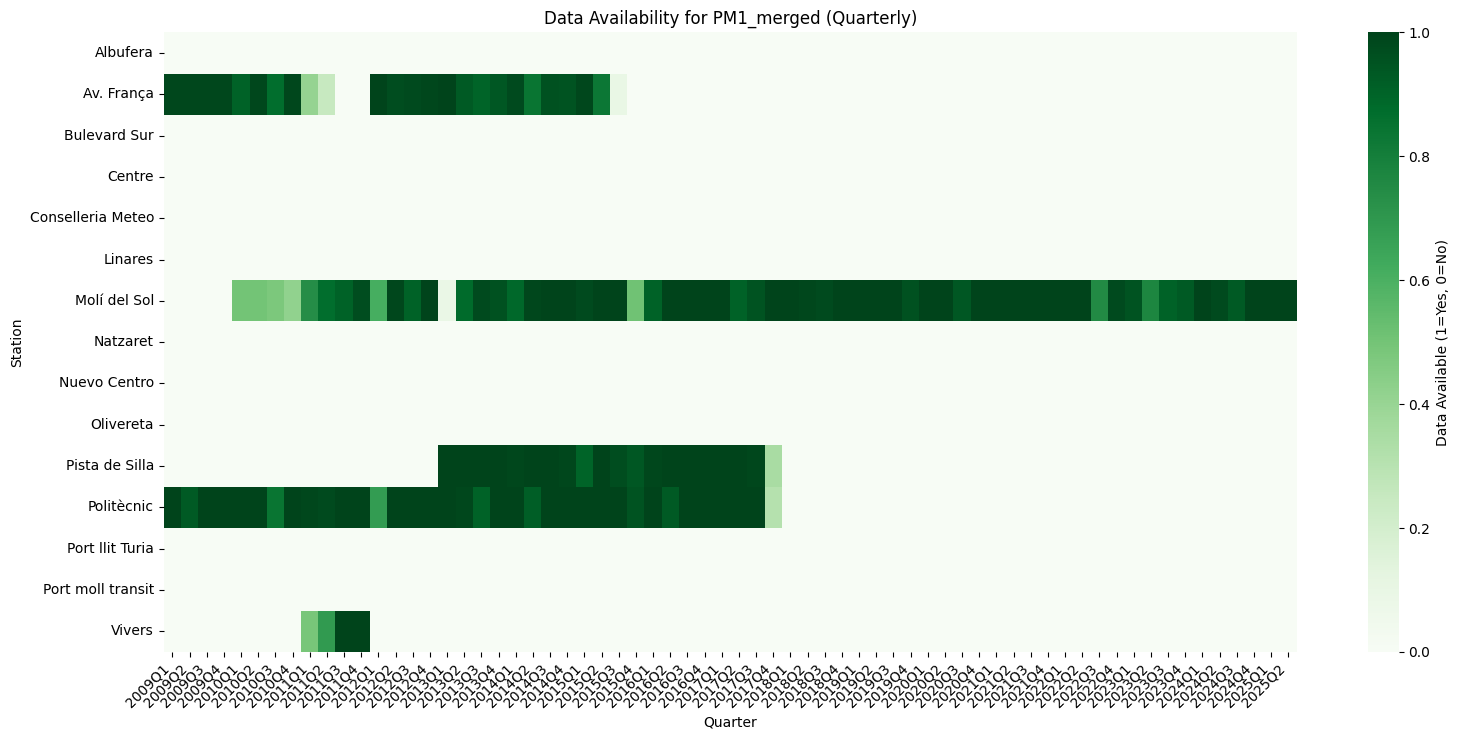

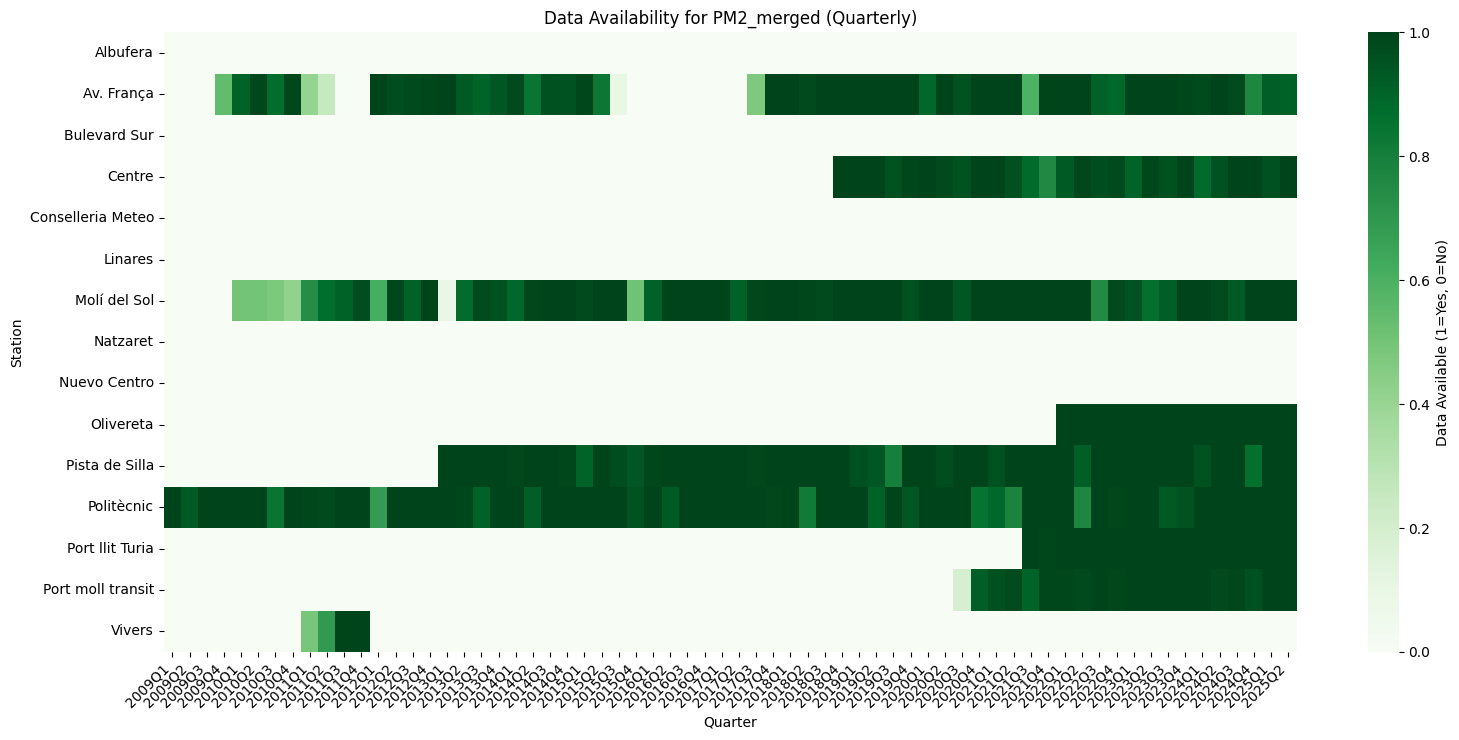

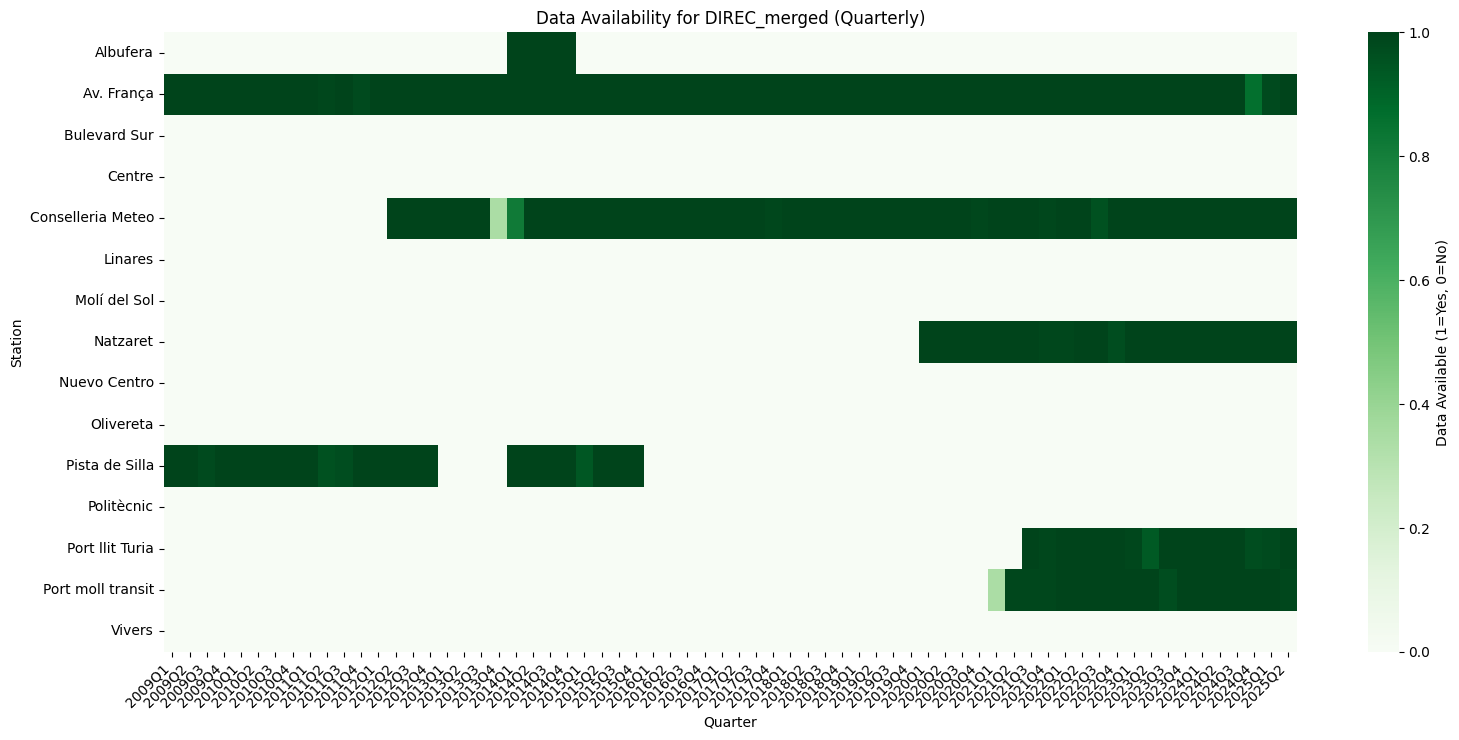

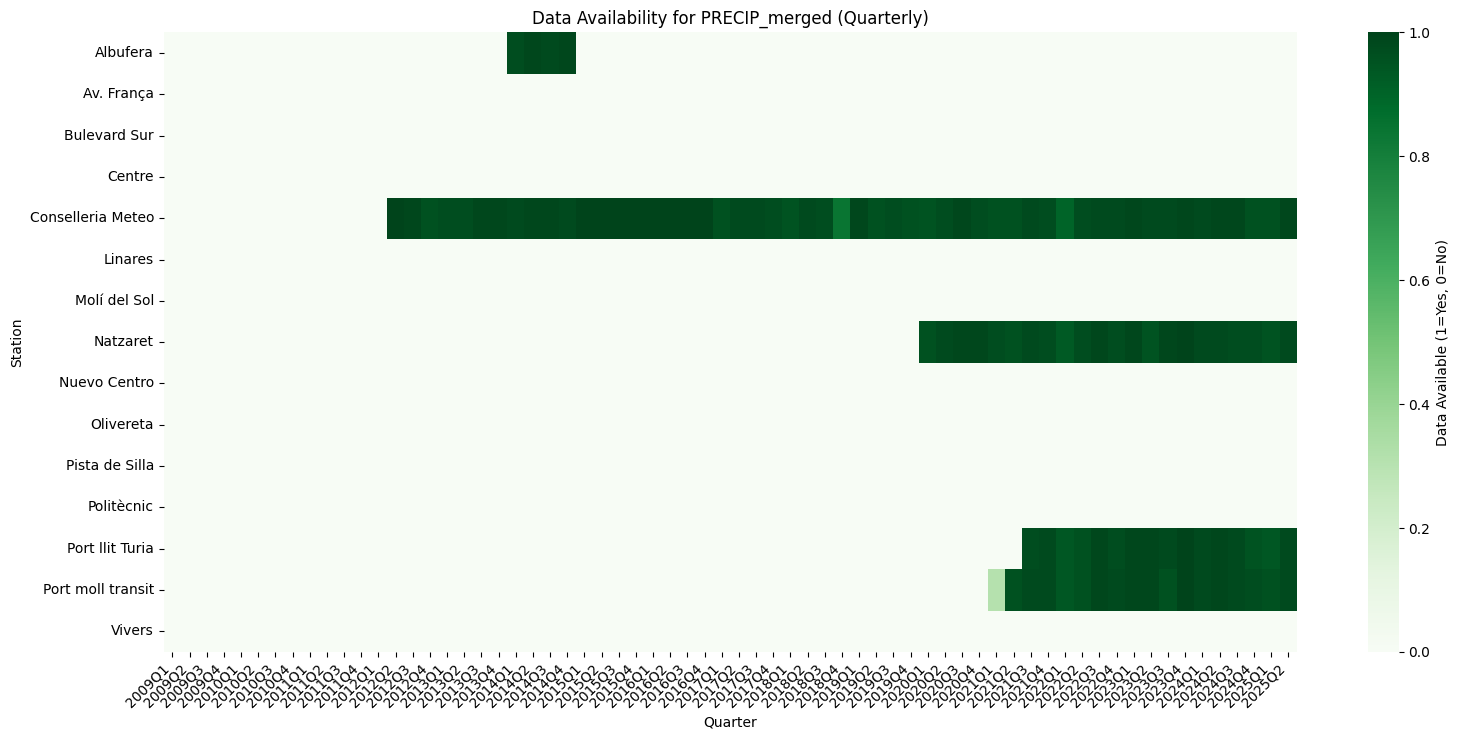

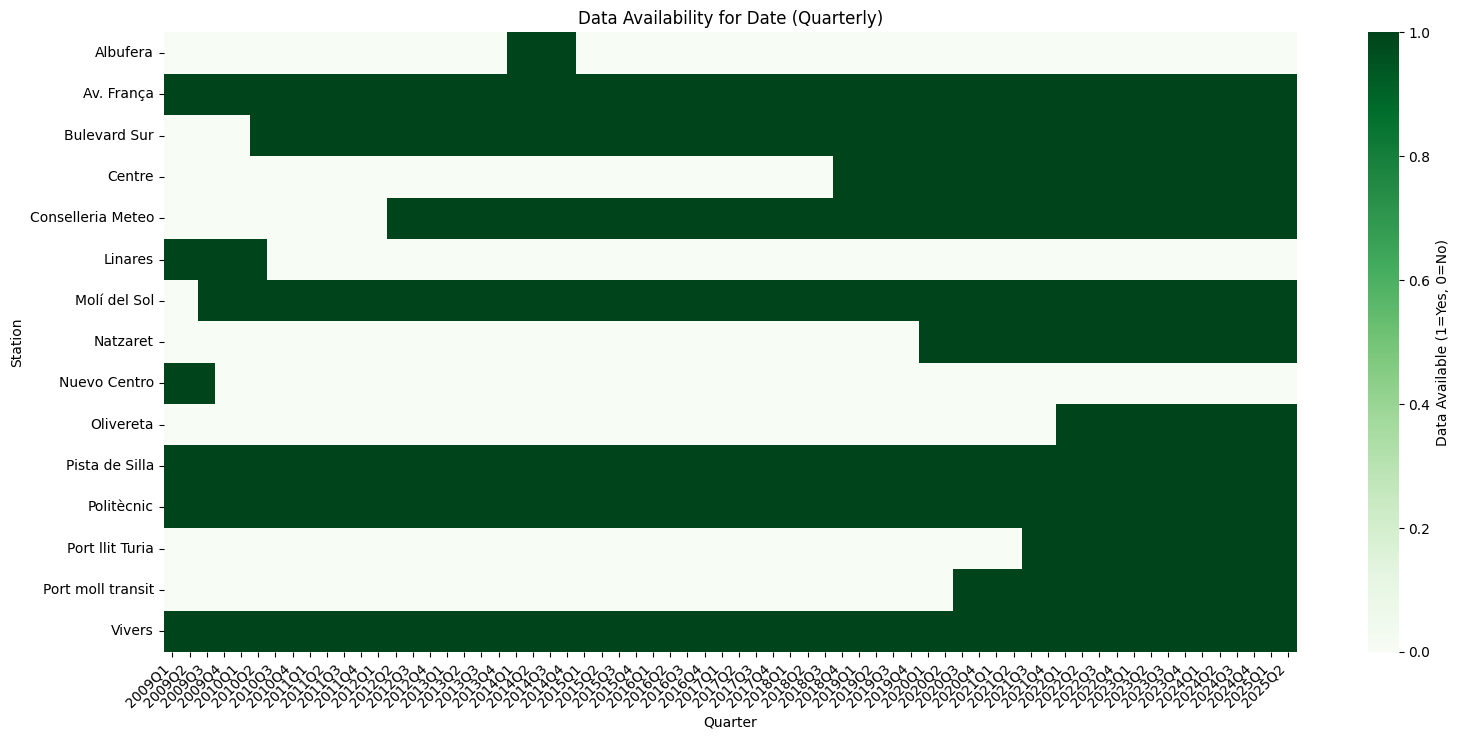

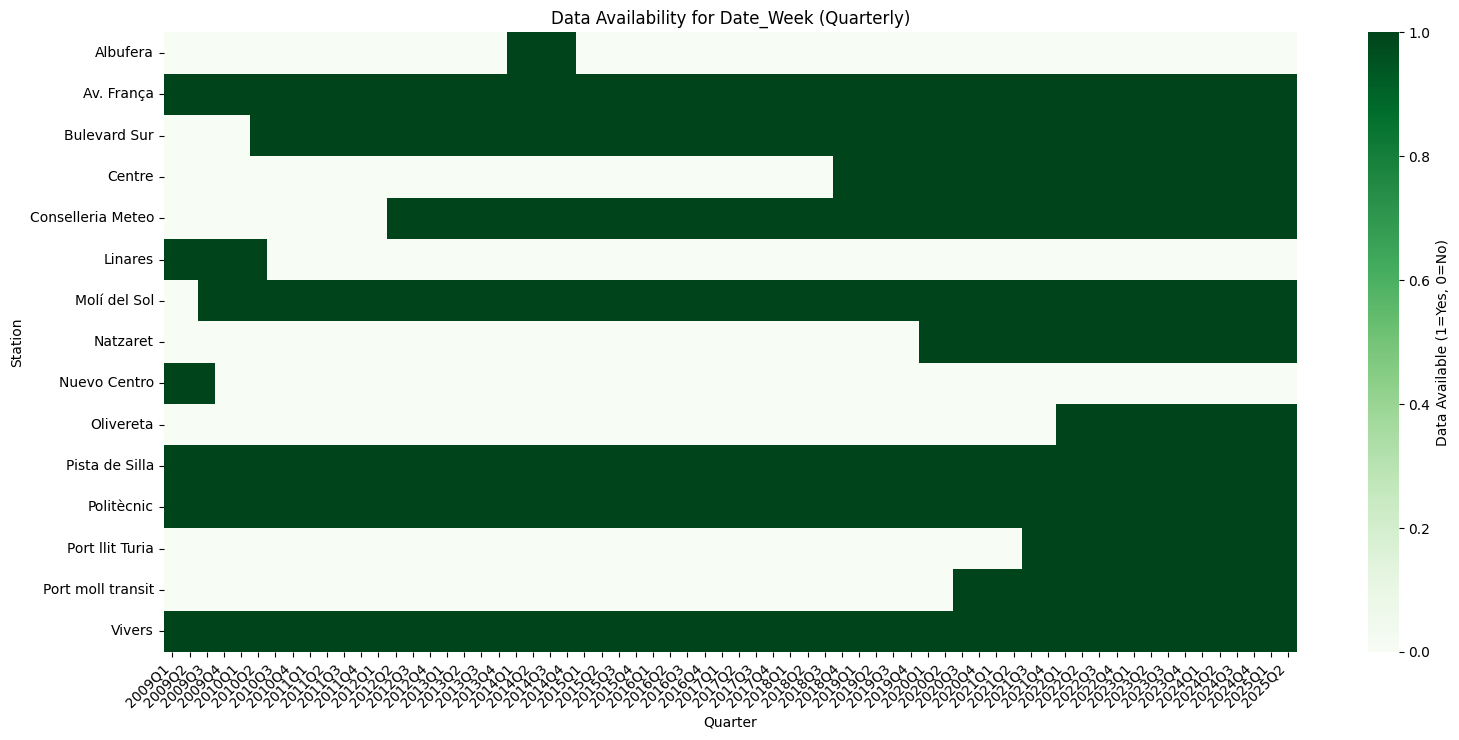

In [18]:
# Data Availability Analysis - All variables with quarterly grouping

import numpy as np
import seaborn as sns

# 1. Set up: Use quarterly grouping for broader columns
data_AQ_VLC["Date_Quarter"] = data_AQ_VLC["Datetime"].dt.to_period("Q")  # Quarterly
stations = sorted(data_AQ_VLC["Estacion"].unique())

# Check all available sensor columns (exclude non-sensor columns)
exclude_cols = ["Estacion", "FECHA Y HORA", "FECHA", "HORA", "Datetime", "Date_Quarter"]
cols_to_check = [col for col in data_AQ_VLC.columns if col not in exclude_cols]

print(f"Analyzing data availability for: {cols_to_check}")

# 2. Build availability matrix with percentages
availability = []
for station in stations:
    df_station = data_AQ_VLC[data_AQ_VLC["Estacion"] == station]
    for col in cols_to_check:
        # Calculate percentage of non-null values per quarter
        quarterly = df_station.groupby("Date_Quarter")[col].apply(lambda x: x.notna().mean()).round(2)
        for date, percentage in quarterly.items():
            availability.append({"Station": station, "Date": date, "Sensor": col, "Available": percentage})


avail_df = pd.DataFrame(availability)

# 3. Create one heatmap per sensor
for sensor in cols_to_check:
    pivot = avail_df[avail_df["Sensor"] == sensor].pivot(index="Station", columns="Date", values="Available")
    
    # Drop all-NaN rows and columns
    pivot = pivot.dropna(how="all", axis=0).dropna(how="all", axis=1)
    
    if pivot.sum().sum() == 0:
        print(f"No data available for {sensor}, skipping plot.")
        continue
        
    plt.figure(figsize=(16, max(6, len(pivot.index)*0.5)))
    # Format x labels to show quarter
    pivot.columns = [str(d) for d in pivot.columns]  # Convert period to string
    
    # Use default colormap (viridis) 
    sns.heatmap(pivot.fillna(0), cmap="Greens", 
                cbar_kws={'label': 'Data Available (1=Yes, 0=No)'}, 
                vmin=0, vmax=1)
    plt.title(f"Data Availability for {sensor} (Quarterly)")
    plt.xlabel("Quarter")
    plt.ylabel("Station")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**Keep only plentyful meaningful data**

In [24]:
# Create streamlined dataframe by dropping unwanted columns

# Define columns to drop - less useful or redundant columns
columns_to_drop = [
    # Original date/time columns (we have Datetime)
    "FECHA Y HORA",
    "FECHA", 
    "HORA",
    "Date_Quarter",
    "Date",
    "Date_Week",
    "Tolueno",
    "Benceno",
    "Xileno",
    "CH4",
    "HCT",
    "HNM",
    "NH3",
    "C8H10",
    "C6H6",
    "C7H8",
    "PST",
    "Veloc.",
    "Veloc.máx.", 
    # Any other columns you want to drop
    # Add more column names here as needed
]

# Check which columns to drop actually exist
existing_drop_cols = [col for col in columns_to_drop if col in data_AQ_VLC.columns]
missing_drop_cols = [col for col in columns_to_drop if col not in data_AQ_VLC.columns]

print("Columns to drop that exist in data:")
print(existing_drop_cols)
print(f"\nColumns to drop not found in data:")
print(missing_drop_cols)

# Create the streamlined dataframe
data_AQ_clean = data_AQ_VLC.drop(columns=existing_drop_cols)

print(f"\nOriginal dataframe shape: {data_AQ_VLC.shape}")
print(f"Streamlined dataframe shape: {data_AQ_clean.shape}")
print(f"Dropped {len(existing_drop_cols)} columns")

# Show the columns we kept
print(f"\nFinal columns in clean dataset:")
for col in sorted(data_AQ_clean.columns):
    print(f"  {col}")
    
# Clean up column names by removing "_merged" suffix
rename_dict = {}
for col in data_AQ_clean.columns:
    if col.endswith("_merged"):
        new_name = col.replace("_merged", "")
        rename_dict[col] = new_name

print("Renaming columns:")
for old, new in rename_dict.items():
    print(f"  {old} -> {new}")

# Rename the columns
data_AQ_clean = data_AQ_clean.rename(columns=rename_dict)

print(f"\nFinal columns in clean dataset:")
for col in sorted(data_AQ_clean.columns):
    print(f"  {col}")

Columns to drop that exist in data:
['FECHA Y HORA', 'FECHA', 'HORA', 'Date_Quarter', 'Date', 'Date_Week', 'Tolueno', 'Benceno', 'Xileno', 'CH4', 'HCT', 'HNM', 'NH3', 'C8H10', 'C6H6', 'C7H8', 'PST', 'Veloc.', 'Veloc.máx.']

Columns to drop not found in data:
[]

Original dataframe shape: (1229169, 37)
Streamlined dataframe shape: (1229169, 18)
Dropped 19 columns

Final columns in clean dataset:
  CO
  DIREC_merged
  Datetime
  Estacion
  H.Rel.
  NO
  NO2
  NOx
  O3
  PM10_merged
  PM1_merged
  PM2_merged
  PRECIP_merged
  Pres.
  R.Sol.
  Ruido
  SO2
  Temp.
Renaming columns:
  PM10_merged -> PM10
  PM1_merged -> PM1
  PM2_merged -> PM2
  DIREC_merged -> DIREC
  PRECIP_merged -> PRECIP

Final columns in clean dataset:
  CO
  DIREC
  Datetime
  Estacion
  H.Rel.
  NO
  NO2
  NOx
  O3
  PM1
  PM10
  PM2
  PRECIP
  Pres.
  R.Sol.
  Ruido
  SO2
  Temp.


**Daily and Weekly Patterns, Outlier Days**

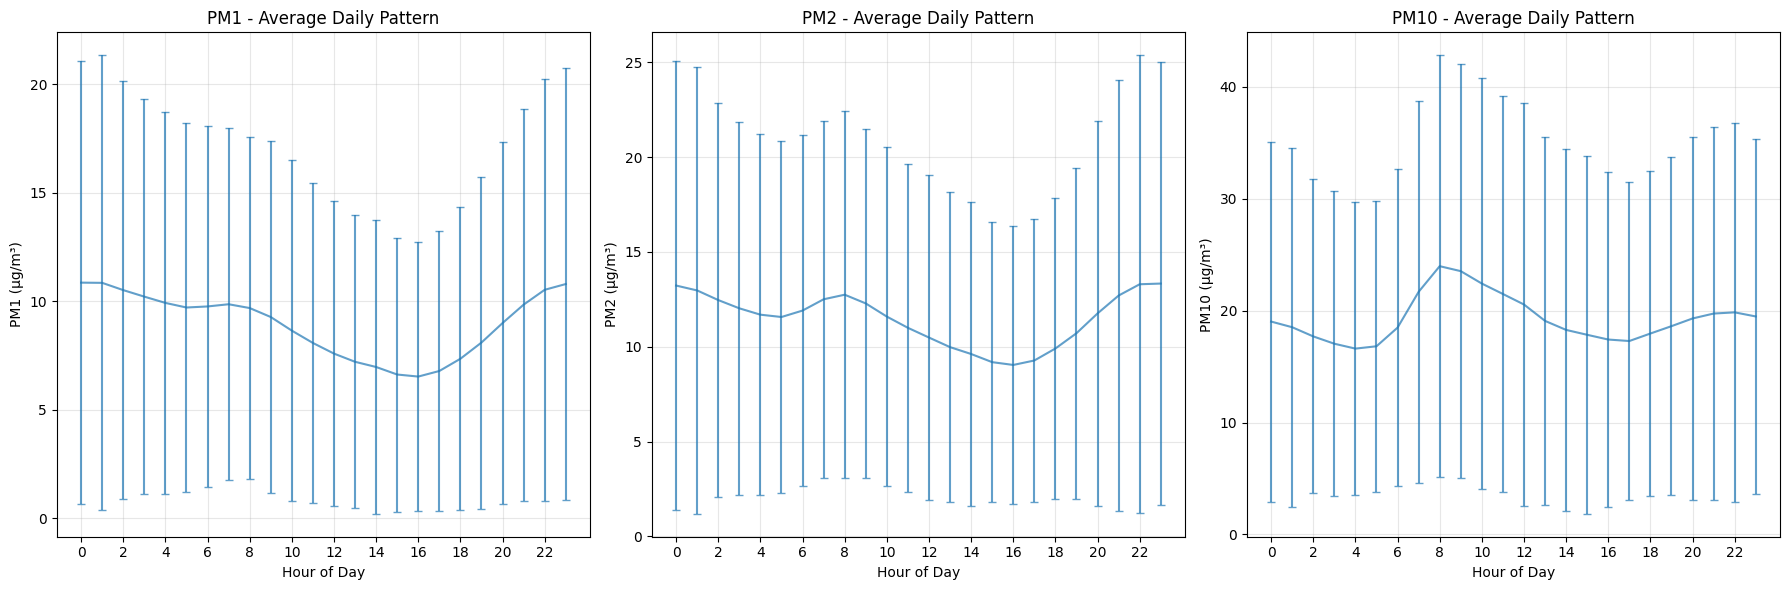

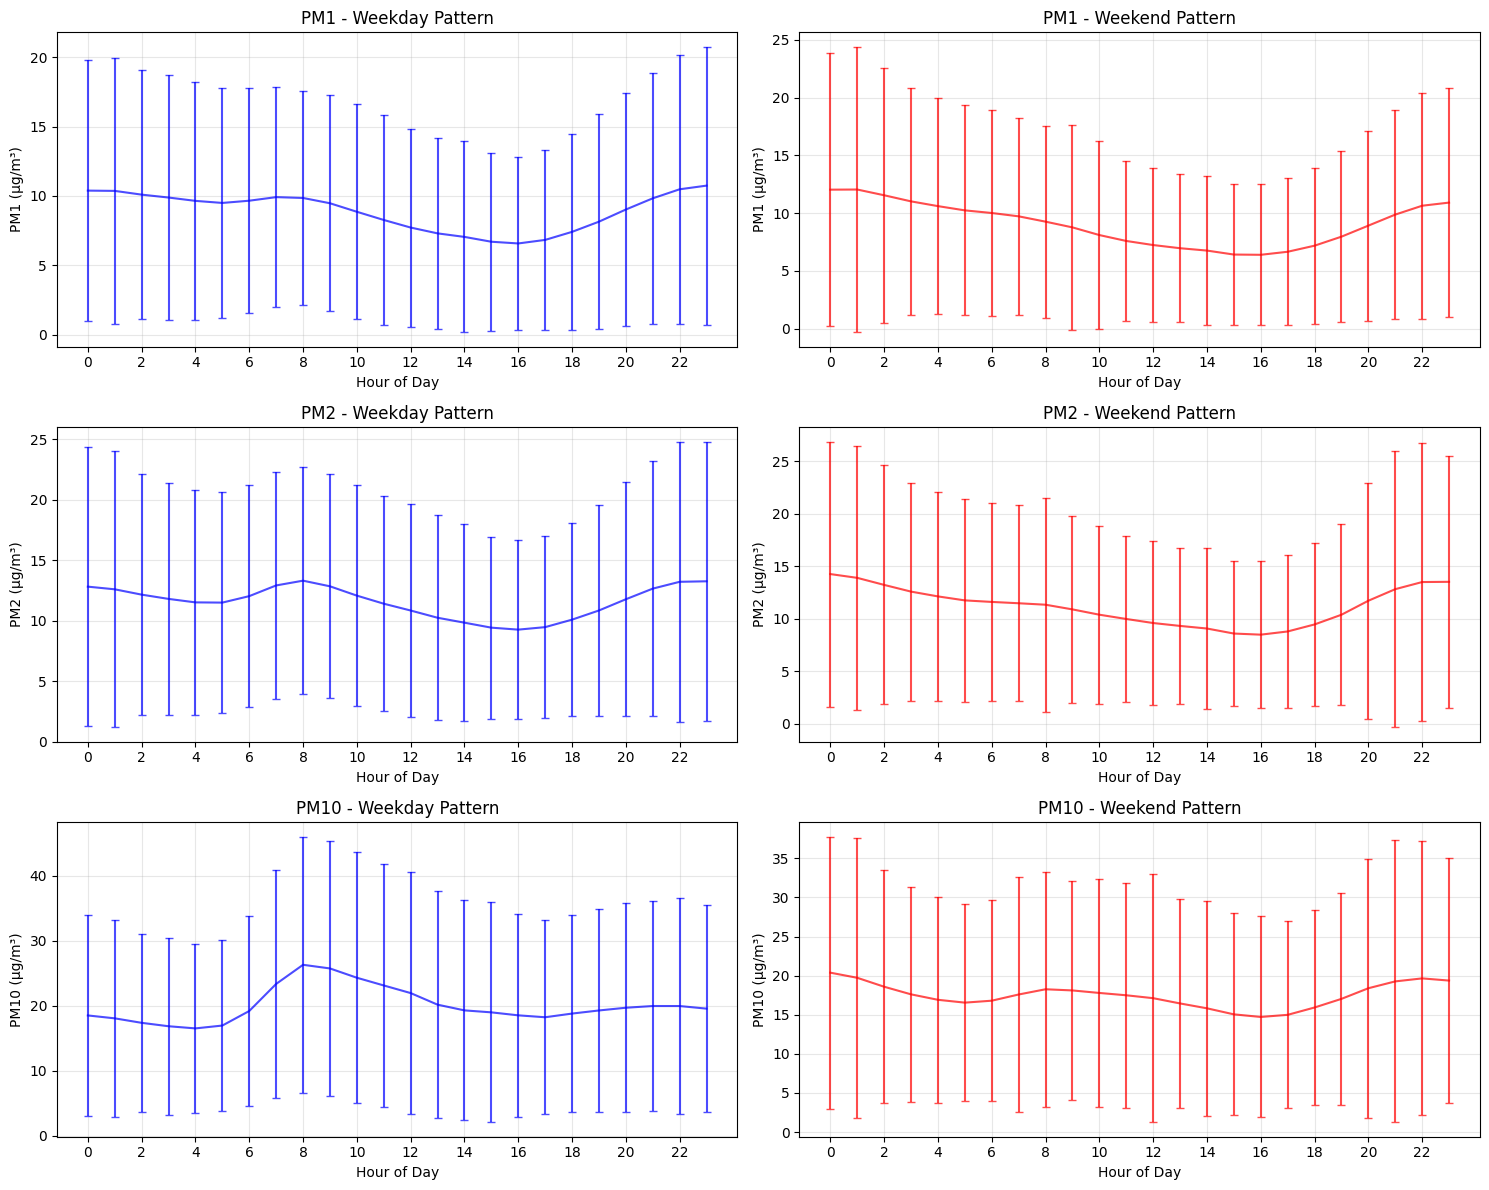

=== OUTLIER ANALYSIS ===

--- PM1 Analysis ---
Overall mean: 8.94 µg/m³
High mean threshold (mean + 2*std): 25.70 µg/m³
High range threshold (95th percentile): 41.50 µg/m³
Number of outlier days: 387

Top 5 outlier days:
  2017-11-17: Mean=70.9, Range=154.0
  2020-02-17: Mean=57.1, Range=21.0
  2018-01-25: Mean=53.3, Range=53.0
  2011-02-10: Mean=49.0, Range=75.0
  2021-02-18: Mean=48.3, Range=24.0

--- PM2 Analysis ---
Overall mean: 11.47 µg/m³
High mean threshold (mean + 2*std): 30.76 µg/m³
High range threshold (95th percentile): 60.00 µg/m³
Number of outlier days: 362

Top 5 outlier days:
  2017-11-17: Mean=67.4, Range=178.0
  2011-02-10: Mean=51.8, Range=75.0
  2020-02-17: Mean=50.9, Range=78.0
  2011-02-09: Mean=49.4, Range=69.0
  2018-01-25: Mean=49.4, Range=61.0

--- PM10 Analysis ---
Overall mean: 19.27 µg/m³
High mean threshold (mean + 2*std): 51.49 µg/m³
High range threshold (95th percentile): 136.00 µg/m³
Number of outlier days: 311

Top 5 outlier days:
  2016-02-23: Mean=11

In [28]:
# Daily Pattern Analysis for PM1, PM2, PM10

import matplotlib.pyplot as plt
import numpy as np

# Extract time components for analysis
data_AQ_clean['Hour'] = data_AQ_clean['Datetime'].dt.hour
data_AQ_clean['DayOfWeek'] = data_AQ_clean['Datetime'].dt.dayofweek  # 0=Monday
data_AQ_clean['Date'] = data_AQ_clean['Datetime'].dt.date

# Focus on PM variables
pm_vars = ['PM1', 'PM2', 'PM10']

# 1. HOURLY PATTERNS - Average by hour of day
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, pm_var in enumerate(pm_vars):
    if pm_var in data_AQ_clean.columns:
        # Calculate hourly averages across all data
        hourly_avg = data_AQ_clean.groupby('Hour')[pm_var].agg(['mean', 'std']).reset_index()
        
        axes[i].errorbar(hourly_avg['Hour'], hourly_avg['mean'], 
                        yerr=hourly_avg['std'], capsize=3, alpha=0.7)
        axes[i].set_title(f'{pm_var} - Average Daily Pattern')
        axes[i].set_xlabel('Hour of Day')
        axes[i].set_ylabel(f'{pm_var} (µg/m³)')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

# 2. WEEKDAY vs WEEKEND PATTERNS
fig, axes = plt.subplots(len(pm_vars), 2, figsize=(15, 12))

for i, pm_var in enumerate(pm_vars):
    if pm_var in data_AQ_clean.columns:
        # Separate weekday (0-4) and weekend (5-6)
        weekday_data = data_AQ_clean[data_AQ_clean['DayOfWeek'] < 5]
        weekend_data = data_AQ_clean[data_AQ_clean['DayOfWeek'] >= 5]
        
        # Weekday pattern
        weekday_hourly = weekday_data.groupby('Hour')[pm_var].agg(['mean', 'std']).reset_index()
        axes[i,0].errorbar(weekday_hourly['Hour'], weekday_hourly['mean'], 
                          yerr=weekday_hourly['std'], capsize=3, color='blue', alpha=0.7)
        axes[i,0].set_title(f'{pm_var} - Weekday Pattern')
        axes[i,0].set_xlabel('Hour of Day')
        axes[i,0].set_ylabel(f'{pm_var} (µg/m³)')
        axes[i,0].grid(True, alpha=0.3)
        axes[i,0].set_xticks(range(0, 24, 2))
        
        # Weekend pattern
        weekend_hourly = weekend_data.groupby('Hour')[pm_var].agg(['mean', 'std']).reset_index()
        axes[i,1].errorbar(weekend_hourly['Hour'], weekend_hourly['mean'], 
                          yerr=weekend_hourly['std'], capsize=3, color='red', alpha=0.7)
        axes[i,1].set_title(f'{pm_var} - Weekend Pattern')
        axes[i,1].set_xlabel('Hour of Day')
        axes[i,1].set_ylabel(f'{pm_var} (µg/m³)')
        axes[i,1].grid(True, alpha=0.3)
        axes[i,1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

# 3. IDENTIFY OUTLIER DAYS - Days with patterns exceeding normal oscillation
print("=== OUTLIER ANALYSIS ===")

for pm_var in pm_vars:
    if pm_var in data_AQ_clean.columns:
        print(f"\n--- {pm_var} Analysis ---")
        
        # Calculate daily statistics
        daily_stats = data_AQ_clean.groupby('Date')[pm_var].agg([
            'mean', 'std', 'min', 'max', 
            lambda x: x.max() - x.min()  # daily range
        ]).reset_index()
        daily_stats.columns = ['Date', 'daily_mean', 'daily_std', 'daily_min', 'daily_max', 'daily_range']
        
        # Overall statistics for comparison
        overall_mean = data_AQ_clean[pm_var].mean()
        overall_std = data_AQ_clean[pm_var].std()
        
        # Define outlier thresholds
        high_mean_threshold = overall_mean + 2 * overall_std
        high_range_threshold = daily_stats['daily_range'].quantile(0.95)  # 95th percentile
        
        # Find outlier days
        outlier_days = daily_stats[
            (daily_stats['daily_mean'] > high_mean_threshold) | 
            (daily_stats['daily_range'] > high_range_threshold)
        ]
        
        print(f"Overall mean: {overall_mean:.2f} µg/m³")
        print(f"High mean threshold (mean + 2*std): {high_mean_threshold:.2f} µg/m³")
        print(f"High range threshold (95th percentile): {high_range_threshold:.2f} µg/m³")
        print(f"Number of outlier days: {len(outlier_days)}")
        
        if len(outlier_days) > 0:
            print("\nTop 5 outlier days:")
            outlier_days_sorted = outlier_days.sort_values('daily_mean', ascending=False).head()
            for _, row in outlier_days_sorted.iterrows():
                print(f"  {row['Date']}: Mean={row['daily_mean']:.1f}, Range={row['daily_range']:.1f}")